In [ ]:
###############################################################
#
# Consumer-Resource model with production.
# Produces eigenvalue plots for symmetric and asymmetric P
# matrices.
# Each resource density = r
# Each species abundance = s
# Consumption matrix C = c*I  ### Completely specialized
#
################################################################

# From Butler, O'Dwyer (2018)

In [4]:
import numpy as np
from numpy.random import normal, uniform
from numpy.linalg import eigvals
import math as mt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"     

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

%matplotlib inline

np.set_printoptions(precision=7)

np.random.seed(999)

# O'Dwyer Model

## Original P functions

In [8]:
## Asymmetric P matrix ##
def asymP(sig, n):

    return abs(normal(0, sig, (n, n))) ### half-normal entries

In [9]:
## Symmetric P matrix ##
def symP(sig, n):
    
    P = np.empty((n, n))
    for i in range(n):
        for j in range(i + 1):
            P[j][i] = P[i][j] = abs(normal(0, sig))
    
    return P

## Vectorized P functions

In [10]:
### Vectorized Asymmetric P matrix
def asymPvec(sig, n, k=1):
    return abs(normal(0, sig, (k, n, n))) # again, a half-normal with mean=1

In [11]:
### Vectorized Symmetric P matrix
def symPvec(sig, n, k=1): # k, number of matrices to generate
    P = abs(normal(0,sig,(k,n,n)))
    P = np.maximum(P,np.transpose(P,(0,2,1))) #transpose each sub-P (only transpose last two dimensions)
    ### Is max an issue? Favors less probable p-values, I guess. Not QUITE normally dist'd 
                            ### after abs and this maximum. Effectively increases sigma?
    
    return P

In [12]:
def symPvec2(sig,n,k=1): ### This way does not use max, but slightly slower than symPvec
    P = abs(normal(0,sig,(k,n,n)))
    inds = np.tril_indices(n, k=-1)
    P[:,inds[1],inds[0]] = P[:,inds[0],inds[1]]
    
    return P

## Eigenvalues, single fixed P

In [13]:
### Original O'Dwyer method for determining/plotting stability
   # Fix a symmetric P, sP, and an asymmetric P, aP.
    # Pick uniform-random equilibria r and s, where unif bounds are chosen to guarantee positive mu and rho
        #mu and rho are only implicit in r and s, could be calculated from Eq 6? in Appendix
     # Evaluate Jacobian at r and s at each P, append eigenvalues
    

sev = np.array([])
aev = np.array([]) 

## Parameters ##

n   = 20      # number of species AND number of resrcs
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

### SEE METHODS FOR mu AND rho

I = np.identity(n)

## Consumption Matrix ##

C = c * I

## Production matrices ##

sP = symP(sig, n)
aP = asymP(sig, n)
#sPvec = symPvec(sig, n)

rlb = n * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                #produces this equilibrium


for k in range(5000): ### originally 5000
    ## Abundances ##
    
    r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
    s = uniform(rlb / 10**4, rlb / 1000)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LA  = -c * s * I
    
    sLB = sP - c * r * I ### the only partitions that differ between symmetric and asymmetric Production models
    aLB = aP - c * r * I

    LC = eps * c * s * I
    LD = np.zeros((n, n)) # DON'T REEVALUATE EVERY ITERATION

    sL  = np.vstack((np.hstack((LA, sLB)), np.hstack((LC, LD))))
    aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))
    
    ## Eigenvalues of Linearized System ##
    
    sev = np.append(sev, eigvals(sL))
    aev = np.append(aev, eigvals(aL))
    
# Why iterating with random populations rather than random P matrices at proper steady states?

In [14]:
# Below, figuring the derivation of 'rlb'
# default PDF of normal, p_norm(x)
# sub for mu=0, sigma=1
# double due to half normal

$$ p_{norm}(x) = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{1}{2} (\frac{x-\mu}{\sigma})^2} $$

$$ p_{norm}(x) = \frac{1}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \frac{2}{{ \sqrt {2\pi } }}e^{-\frac{1}{2} x^2} $$
$$ p_{halfnorm}(x) = \sqrt{\frac{2}{\pi}}e^{-\frac{1}{2} x^2} $$

In [15]:
# expectation of the above is np.sqrt(2/np.pi)

$$ rlb = \frac{n  \sigma  \sqrt{\frac{2}{\pi}} } {c  \epsilon} $$

$$ rlb = \frac{20  \sqrt{\frac{2}{\pi}} } {0.25}$$

$$ rlb = 80  \sqrt{\frac{2}{\pi}} $$

### Eigenvalue hexbin plots

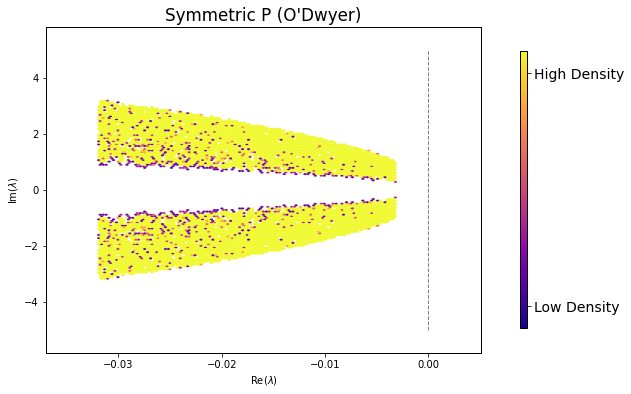

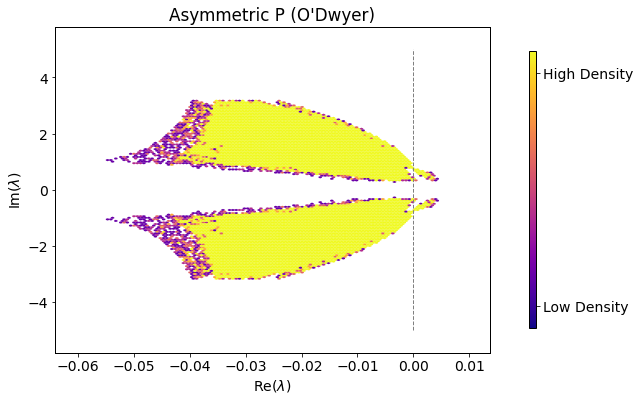

In [16]:
## Plot eigenvalues of linearized system ##

for i, q in enumerate([sev, aev]): # i index, q current value

    x = q.real
    y = q.imag

    plt.rcParams["axes.edgecolor"] = "black" 
    plt.rcParams["axes.linewidth"] = 1 
    
    fig, ax = plt.subplots(figsize = (10, 6))

    #cmap = plt.cm.viridis_r  ### old, gets an error
    cmap = mpl.cm.get_cmap("plasma").copy()
    cmap.set_under(color = 'white', alpha = 0) 

    plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

    font = {'size' : 14}
    plt.rc('font', **font)

    plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

    plt.xlabel(r'Re($\lambda$)')
    plt.ylabel(r'Im($\lambda$)')

    plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
    ### originally, (10**(-8), 2.0)

    xmin, xmax = plt.xlim()
    nxm = (xmax - xmin) / 10 ### def'n some padding/margins
    plt.xlim((xmin - nxm, xmax + nxm))

    
    ### Adjusting Re axis tick marks
    if i==0: ### symmetric P
        loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
        ax.xaxis.set_major_locator(loc)
        plt.title('Symmetric P (O\'Dwyer)')
    if i==1: ### asymetric P
        loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
        ax.xaxis.set_major_locator(loc)
        plt.title('Asymmetric P (O\'Dwyer)')

        

    ymin, ymax = plt.ylim()
    nym = (ymax - ymin) / 3
    plt.ylim((ymin - nym, ymax + nym))

    cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
    locs = cb.get_ticks()
    tl = locs[-1] * 2 / 25
    cb.set_ticks([tl, locs[-1] - tl])
    cb.set_ticklabels(['Low Density', 'High Density'])
        
plt.show();

## Frequency of stable n-size systems

In [17]:
### Original O'Dwyer method for determining/plotting stability
   # Do same as before but with k = 100 trials
    
k_test = 100
ns_test = list(range(1,61))
percents_stable_Odw = []

## Parameters ##
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1       # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES

for nn in ns_test:
    
    aev = np.array([]) # just make new eigval array for each n, easier to just reshape after appending
                            # all eigvals for one system size (n) and append the stability_percent, then repeat
    I = np.identity(nn)

    ## Consumption Matrix ##
    C = c * I

    ## Production matrices ##
    sP = symP(sig, nn)
    aP = asymP(sig, nn)
    #sPvec = symPvec(sig, n)

    rlb = nn * sig * mt.sqrt(2 / mt.pi) / (c * eps) # mu and rho are hidden, i.e. some choice of those vector
                                                    #produces this equilibrium

    LD = np.zeros((nn, nn))

    for k in range(k_test): ### originally 5000
        ## Equilibrium Abundances ##
        r = uniform(rlb, 10 * rlb)           ### varying the densities at which Jacobian is evaluated
        s = uniform(rlb / 10**4, rlb / 1000)

        ## Linearized System ##
           ### Jacobian, L, eval'd at steady state
        #     [ LA | aLB]
        #aL = [---------]
        #     [ LC | LD ]
        LA  = -c * s * I

        aLB = aP - c * r * I

        LC = eps * c * s * I
        LD = np.zeros((nn, nn))

        aL  = np.vstack((np.hstack((LA, aLB)), np.hstack((LC, LD))))

        ## Eigenvalues of Linearized System ##

        aev = np.append(aev, eigvals(aL))
    
    aev = aev.reshape(k_test,2*nn)
    pos_real_cts = np.sum(aev>0,1)
    
    percents_stable_Odw.append(len(pos_real_cts[pos_real_cts==0])/k_test)
        

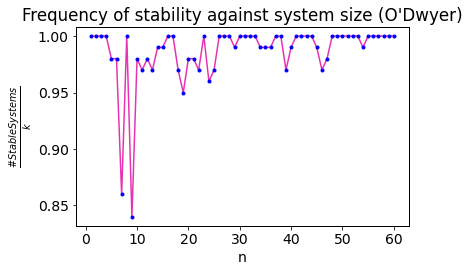

In [18]:
y_data = np.array(percents_stable_Odw)
x_data = np.array(ns_test)

plt.plot(x_data,y_data, color=(0.9,0.2,0.7));
plt.plot(x_data,y_data, 'b.');
plt.title('Frequency of stability against system size (O\'Dwyer)');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
plt.show();

# When using AN EVEN HIGHER SAMPLE SIZE (k=1000 vs. k=100 down below), still very chaotic-looking
    # but with dip near n=[8,12]. Hrm...
    # Also, very stable.

In [19]:
x_data[np.argmin(y_data)] # Least chance of having stable system at n=9

9

# 'Random P and Corresponding Equilibria' Approach

In [141]:
###########################################################################################
### Instead, consider randomizing the (n,n) P(roduction matrix) and eval'ing its Jacobian only at 
    ### the corresponding steady state.
# Choose k = 5000
# make (k,n,n) array (5000 P matrices)
# make (k,n,1) array (5000 R_stars)
# ""                 (5000 S_stars)

## Setup for new approach

In [142]:
def extract_block_diags(A,block_size):
    '''
    A, square matrix whose (square) block diagonals of shape (block_size,block_size) are to be extracted
    
    This function has zero error handling. Make sure block_size fits the matrix, or whatever.
    '''
    block_diags = np.lib.stride_tricks.sliding_window_view(A,(block_size,block_size))[::block_size,::block_size]
    num_blocks = int(A.shape[0]/block_size)
    block_inds = list(range(num_blocks))
    
    return block_diags[block_inds,block_inds,:,:]

In [143]:
### According to Butler/O'Dwyer, for any CHOICE of (+) mu and rho, the formulae below will produce feasible Steady States

$\vec{R^*} = (C^T)^{-1}\frac{1}{\epsilon}(P^T \vec{1} + \vec{\mu})$)

In [144]:
### Resource-Competition Steady State vectors (R_star and S_star)
# Why are Rstars in the range of r_i in [1,100]??? Any way to normalize/nondimensionalize the model?

def R_star_gen(C,P,eps,mu): # P is actually 3-dimensional matrix (k nxn sub-P-matrices)
    '''
    Generates stack of steady state vectors R_star, where 0th dimension selects the sub-P to which 
    that particular R_star corresponds (i.e. R_star is the equilibrium for the Jacobian formed with that sub-p).
    
    No argument for number of sub-R_stars because that is inferred from 0th dimension of P argument.
    '''
    
    k = P.shape[0]
    n = P.shape[-1]
    mu = np.tile(mu,(k,1,1))
    
    #C = np.tile(C,(k,1,1)) # OLD: stack C k times so that it can be dotted with each sub-Ps
                                # np.dot() does not broadcast, I think. Have to manually add 3rd dimension
    #A = np.linalg.inv(np.transpose(C,(0,2,1)))*(1/eps) # split up into A,v for readability
    A = np.linalg.inv(C.T)*(1/eps) # A is just (k,n,n)
    v = np.sum(np.transpose(P,(0,2,1)), 2).reshape(k,n,1) + mu #take row sums of P transpose, reshape to add 
    
    # How to pairwise dot an array of 2D matrices with array of column vectors?
    
    R_star = np.tensordot(A,v,axes=([1],[1]))
    R_star = R_star.reshape(n,k).T.reshape(k,n,1)
    #np.tensordot(I,b,axes=([1],[1])).reshape(2,3).T.reshape(3,2,1)
    return R_star

$\vec{S^*} = [(R^{*}_{diag})C - P]^{-1} \vec{\rho}$


In [145]:
def S_star_gen(C,P,R_star,rho):
    k = P.shape[0]
    n = P.shape[1]
    
    # How get (k,n,n) array of R_diags, where each of the k (n,n)'s is a diagonal array with the k-th R_star as its entries?
    # fill main diagonal with flattened R_stars (it will be k*n x k*n), then extract the k (n,n) block main diagonal matrices
    
    # Now, we have extract_block_diags()
    
    R_diag = np.zeros((k*n,k*n))
    np.fill_diagonal(R_diag, R_star.reshape(k*n,))
    # now, R_diag is big array
    R_diag = extract_block_diags(R_diag, n) # get each R_diag in (k,n,n)-shaped array
    
    ### FIX THIS LATER FOR NON-IDENTITY C ################################
    #  RC = np.dot(R_diag, C) # real way would be sth like this
    RC = R_diag
    
    A = np.linalg.inv(RC - P) # pairwise subtract RC and P
    #S_star = np.dot(A, rho)  # in a perfect world, this is the answer
    
    # this time, we have many different sub-A and constant rho
    S_star = np.tensordot(A,rho.reshape(1,n,1),axes=([2],[1])) #.reshape(n,k).T.reshape(k,n,1) # we do not live in a perfect world

    return S_star.reshape(k,n,1)


In [146]:
### THIS IS (seems to be?) HOW YOU DOT A BUNCH OF MATRICES (only works for single matrix, many vectors)

# b = np.random.rand(6).reshape(3,2,1)
# b

# I = np.identity(2) #2x2
# b.shape # 3x2x1

# out = np.tensordot(I,b,axes=([1],[1]))
# #out
# out = out.reshape(2,3)
# #out
# out = out.T.reshape(3,2,1)
# out.shape
# out



## Testing eigvals of new vectorized system

In [147]:
### Now, can generate k many P matrices, together with shape (k,n,n), and the corresponding R_stars and S_stars for Jacobian at equilibrium

### MAKE eigenvalue generator INTO A FUNCTION

sEVs = np.array([])
aEVs = np.array([])

## Parameters ##

n   = 20      # number of species AND number of resrcs --> Jacobians will be (2*n,2*n)
k = 750       # number of systems to generate
eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
sig = 1      # std deviation of production rates? Yes, also for abundances?
c   = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
#mu = np.random.unif(0,1,n) 
mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
#rho = np.random.unif(0,1,n)
rho = (np.ones(n)*0.5).reshape(n,1)


### SEE METHODS in O'Dwyer FOR mu AND rho formulae if needed

I = np.identity(n)

## Consumption Matrix ##
C = c * I

### Generating Random P-matrices, fixing mu and rho, and eval'ing Jacobian at corresponding equilibria
    ### Then, find dominant eigenvalues.
    ### Each system will contribute 2*n eigenvalues, so we can reshape eigval list to later determine how many systems had a stable equilibrium

## Production matrices ##
sP = symPvec2(sig, n, k)
aP = asymPvec(sig, n, k)


## Equilibrium Abundances ##
sR_star = R_star_gen(C,sP, eps, mu)
sS_star = S_star_gen(C,sP, sR_star, rho)

aR_star = R_star_gen(C,aP, eps, mu)
aS_star = S_star_gen(C,aP, aR_star, rho)


## Linearized System ##
   ### Jacobian, L, eval'd at steady state
#     [ LA | LB ]
#aL = [---------]
#     [ LC | LD ]

# Community Matrix for Symmetric P
sLA  = -c * sS_star * I
sLB = sP - c * sR_star * I
sLC = eps * c * sS_star * I

# Community Matrix for Asymmetric P
aLA = -c * aS_star * I
aLB = aP - c * aR_star * I
aLC = eps * c * aS_star * I

LD = np.zeros((k, n, n)) # same for both cases P


sL  = np.concatenate((np.concatenate((sLA, sLB),2), np.concatenate((sLC, LD),2)), 1)
# aL  = np.vstack((np.hstack((aLA, aLB)), np.hstack((aLC, LD))))
aL  = np.concatenate((np.concatenate((aLA, aLB),2), np.concatenate((aLC, LD),2)), 1)


## Eigenvalues of Linearized System ##

sEVs = np.append(sEVs, eigvals(sL)) # just turns EVs from an array into a list???
aEVs = np.append(aEVs, eigvals(aL))

In [148]:
# eigvals(sL).shape
# sEVs.shape

## What is going on with the tendency for eigvals ~=~ 0.4???

## Function for eigvals of our random systems

In [149]:
def eigval_gen(P,eps,mu,rho): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Gets eigvals of system given P and parameters.
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    
    EVs = np.array([])

    ## Parameters ##
    n = P.shape[-1]
    k = P.shape[0]

    ## Consumption Matrix ##
    c = 1.0 # Keeps cool curve from 0-1, chaotic-looking when > 1
    I = np.identity(n)
    C = c * I

    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))


    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I


    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)


    # EVs = np.append(EVs, eigvals(L)) # old
    # print(P)
    return eigvals(L)

In [150]:
# old rand_eigval_gen() is minimized below this cell
## new eigval_gen() above just requires that you make your own P-matrices now.
### That way, you can keep track of the P-matrices that led to the eigvals that you get.

In [151]:
def rand_eigval_gen(n, k, sig = 1, symmetric=True): # For now, just identity C, ADD AS ARGUMENT LATER
    '''
    Takes same arguments as (a)symPvec(), but performs all of the eigenvalue calcs for each of the k matrices
    
    Needs to be updated to take C as argument. For now, just uses identity matrix for C (perfect specialists).
    Also, mu, rho, and epsilon.
    '''
    
    EVs = np.array([])

    ## Parameters ##

    # n   = 20      # number of species AND number of resrcs
    # k = 750        # number of systems to generate
    eps = 0.25    # efficiency, WHY SAME FOR EACH SPECIES, scales consumption
    # sig = 25      # std deviation of production rates? Yes, also for abundances?
    c = 1       # equal consumption rate, WHY SAME FOR EACH SPECIES
    #mu = np.random.unif(0,1,n) 
    mu = (np.ones(n)*0.5).reshape(n,1) # R_star_gen takes 2D mu
    #rho = np.random.unif(0,1,n)
    rho = (np.ones(n)*0.5).reshape(n,1)
    ### SEE METHODS FOR mu AND rho


    ## Consumption Matrix ##
    I = np.identity(n)
    C = c * I
    # C = np.identity(n)

    
    # only difference between symmetric=True and otherwise is the call to symPvec2() or asymPvec()
        
    ## Choice of Production matrices ##
    if (symmetric):
        P = symPvec2(sig, n, k)
    else:
        P = asymPvec(sig, n, k)
    
    ## Linearized System ##
       ### Jacobian, L, eval'd at steady state
    #     [ LA | aLB]
    #aL = [---------]
    #     [ LC | LD ]
    LD = np.zeros((k, n, n))


    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)

    # Community Matrix Partitions
    LA  = -c * S_star * I
    LB = P - c * R_star * I
    LC = eps * c * S_star * I


    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)


    # EVs = np.append(EVs, eigvals(L)) # old
    # print(P)
    return eigvals(L)

## Frequency of stable n-size systems

In [152]:
# temporary fix to all of the P.shape prints

# small systems (small n) almost Never unstable

ns_test = list(range(2,41))
percents_stable = []

k_test=100
eps = 0.25

for nn in ns_test:
    n_test = nn
    # ev_ex = rand_eigval_gen(n_test,k_test,sig = 1, symmetric=False)
    
    P_ex = asymPvec(sig = 1, n = n_test, k=k_test)
    mu_ex = (np.ones(n_test)*0.5).reshape(n_test,1)
    rho_ex = (np.ones(n_test)*0.5).reshape(n_test,1)

    ev_ex = eigval_gen(P_ex, eps, mu_ex, rho_ex)

    
    reals = ev_ex.real

    
    pos_real_cts = np.sum(reals>0,-1) # DUE TO COMPLEX CONJUGATES, REALLY ONLY HALF THIS MANY ??? I GUESS, BUT
                            # EVERY EIGVAL HAS COMPLEX CONJUGATE, SO THE FREQUENCY CALC WORKS OUT JUST AS WELL.

    percents_stable.append(len(pos_real_cts[pos_real_cts==0])/k_test) # ratio of stable systems to total systems (k)


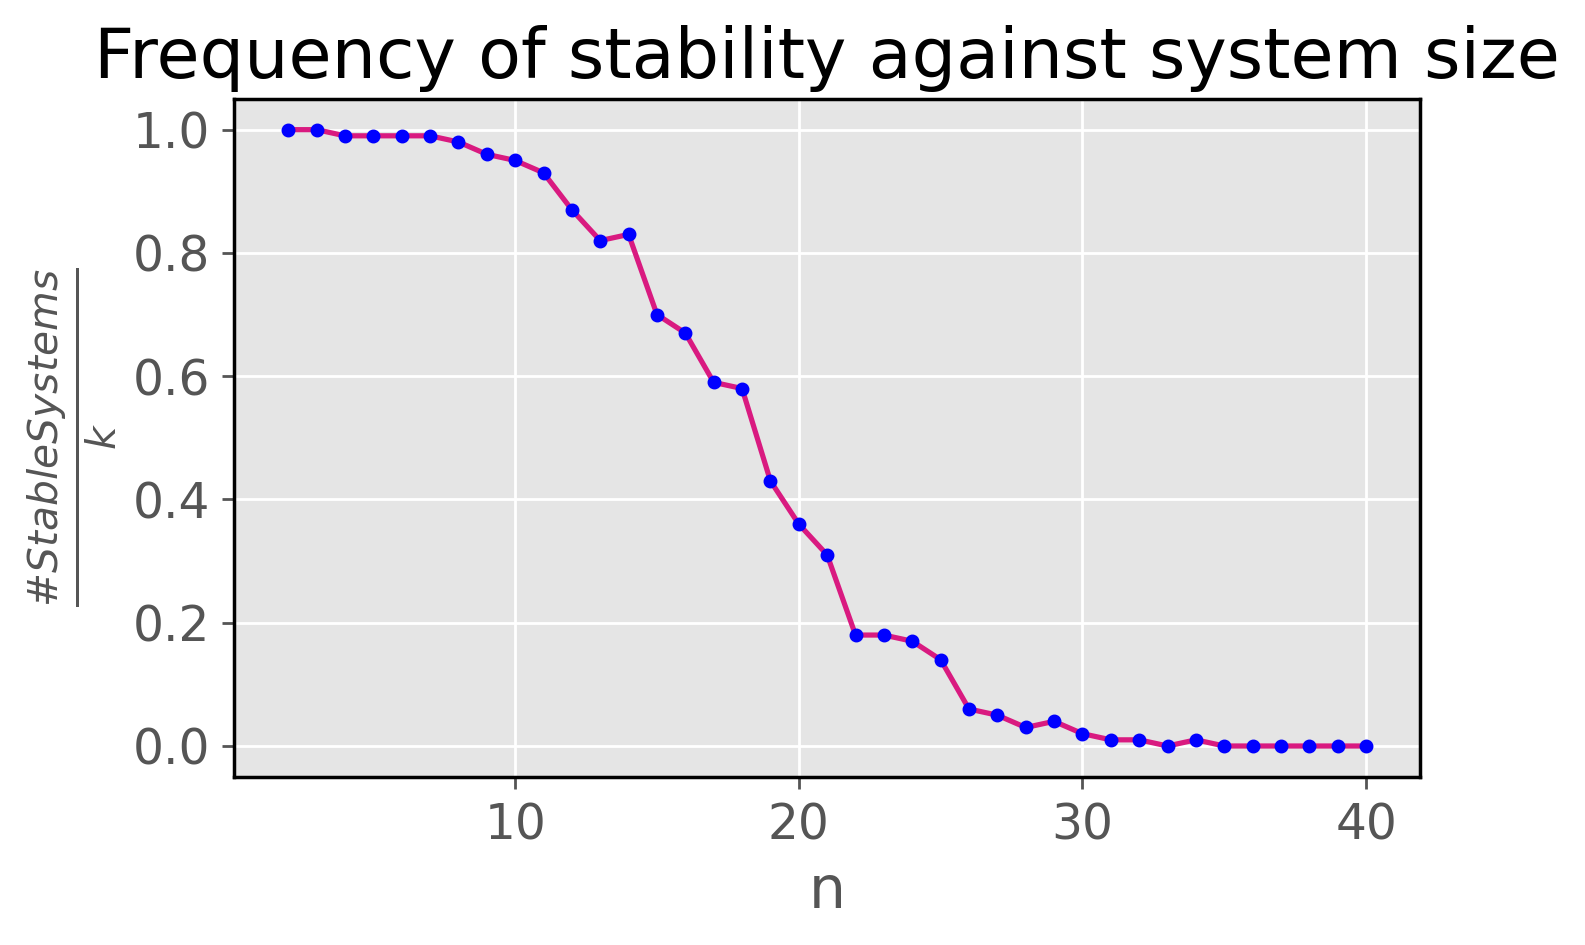

In [153]:
xdata = np.array(ns_test)
ydata = np.array(percents_stable)


# I forgot how to suppress matplotlib output automatically
plt.plot(xdata,ydata, color=(0.85,0.1,0.5));
plt.plot(xdata,ydata, 'b.');

plt.title('Frequency of stability against system size');
plt.xlabel('n');
plt.ylabel(r'$\frac{\# Stable Systems}{k}$');
plt.tight_layout();
# looks like logistic growth (decay, really)
plt.show();
# presence of exponentials makes enough sense given the type of math going on
# Fit with Negative binomial ( parameters )

The above data have a form similar to
$$ F(x) = a\frac{e^{r(x-d)}}{c+e^{r(x-d)}}, $$
with reals $r<0, a,c,d>0$.

### Fitting the peculiar curve

In [154]:
from scipy.optimize import curve_fit

In [155]:
def logistic(x, a, r, c, d): # Model Guess 1: Logistic Decay
    y = a * (np.e**(r*(x-d)) / (c + np.e**(r*(x-d))))
    return y

# Model Guess 2: Negative Binomial (Failure Probability)

In [156]:
guess = [1, -0.1, 0.9, 20] # guess from playing with desmos sliders
parameters, covariance = curve_fit(logistic, xdata, ydata, p0 = guess) # least-squares default?
fit_a = parameters[0]
fit_r = parameters[1]
fit_c = parameters[2]
fit_d = parameters[3]
print(fit_a)
print(fit_r)
print(fit_c)
print(fit_d)

1.0096414795875925
-0.31590225064497723
0.8775447660192874
17.787572746075856


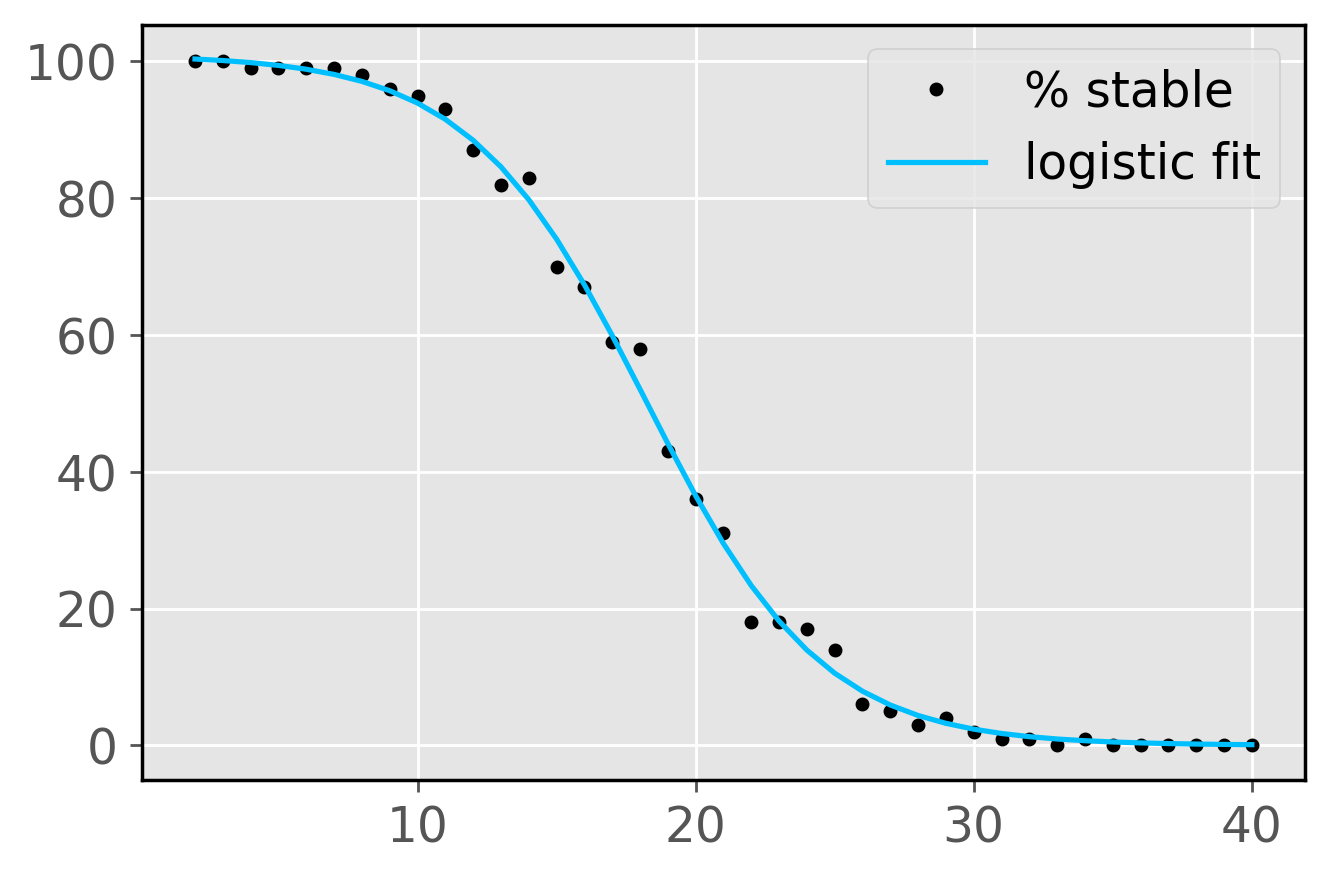

In [157]:
fit_logistic_y = logistic(xdata, fit_a, fit_r, fit_c, fit_d)
plt.plot(xdata, 100*ydata, 'k.', label='% stable');
plt.plot(xdata, 100*fit_logistic_y, 'deepskyblue', label='logistic fit');
plt.legend();

### Back to plotting eigvals

C:\Users\riley\AppData\Local\Temp/ipykernel_5696/3714282650.py:87: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)


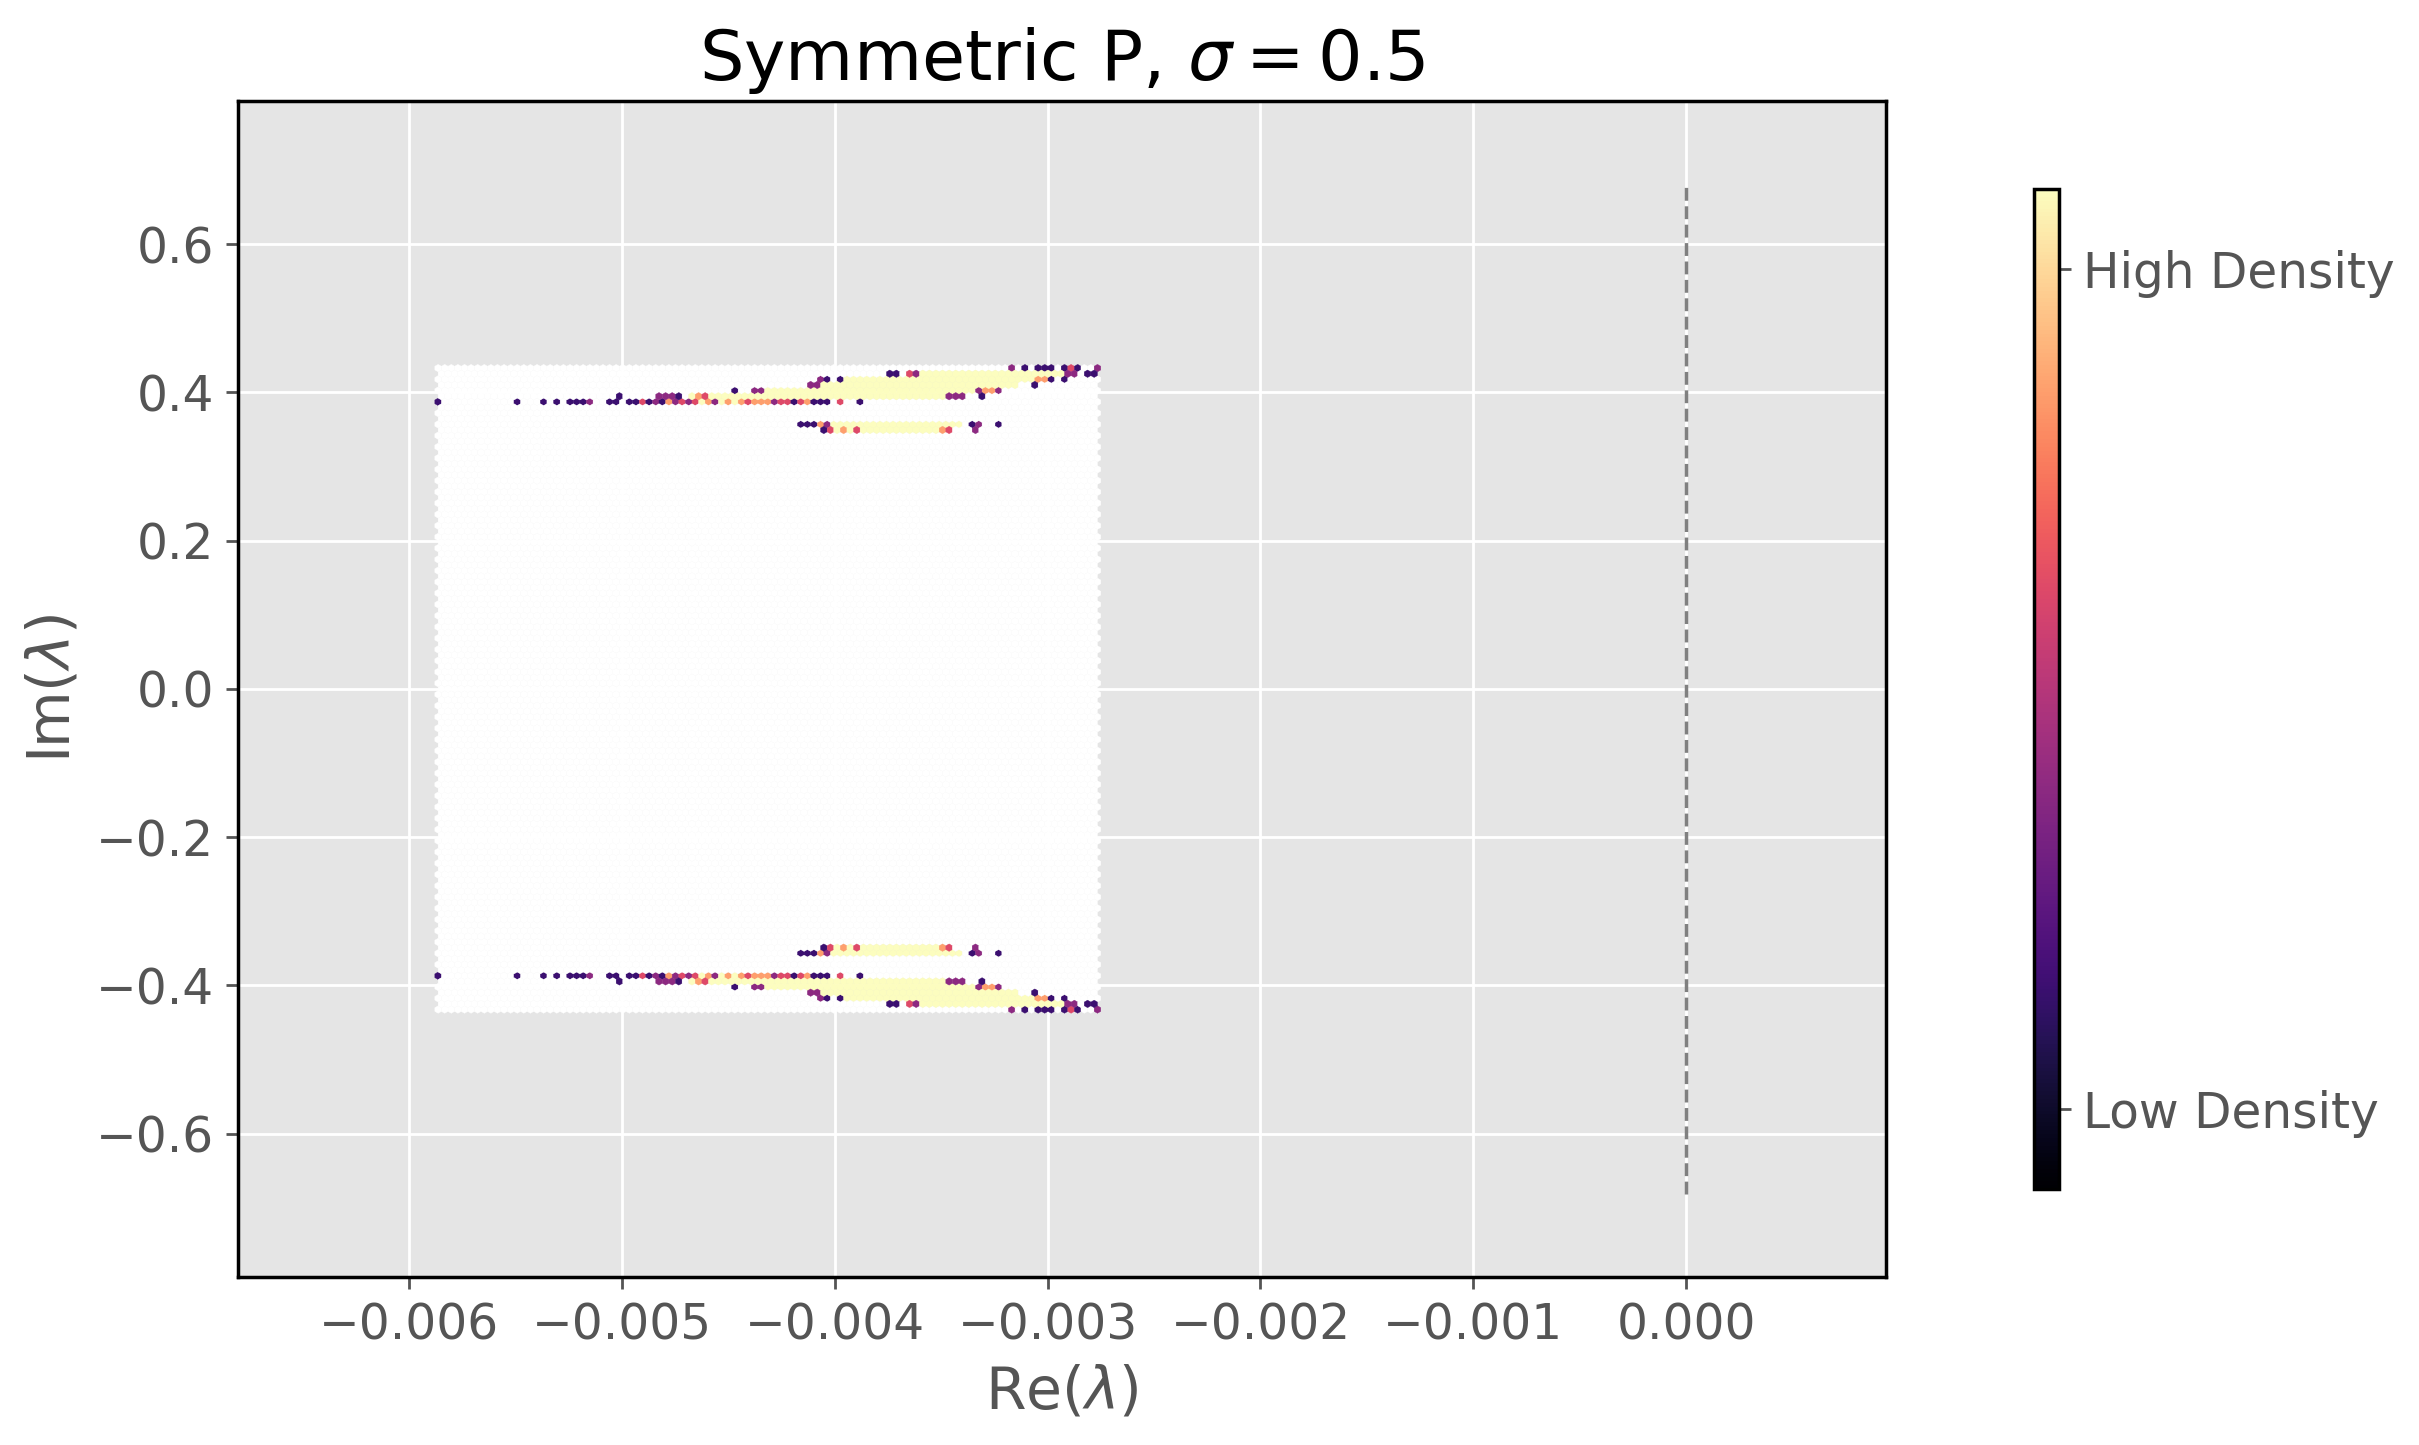

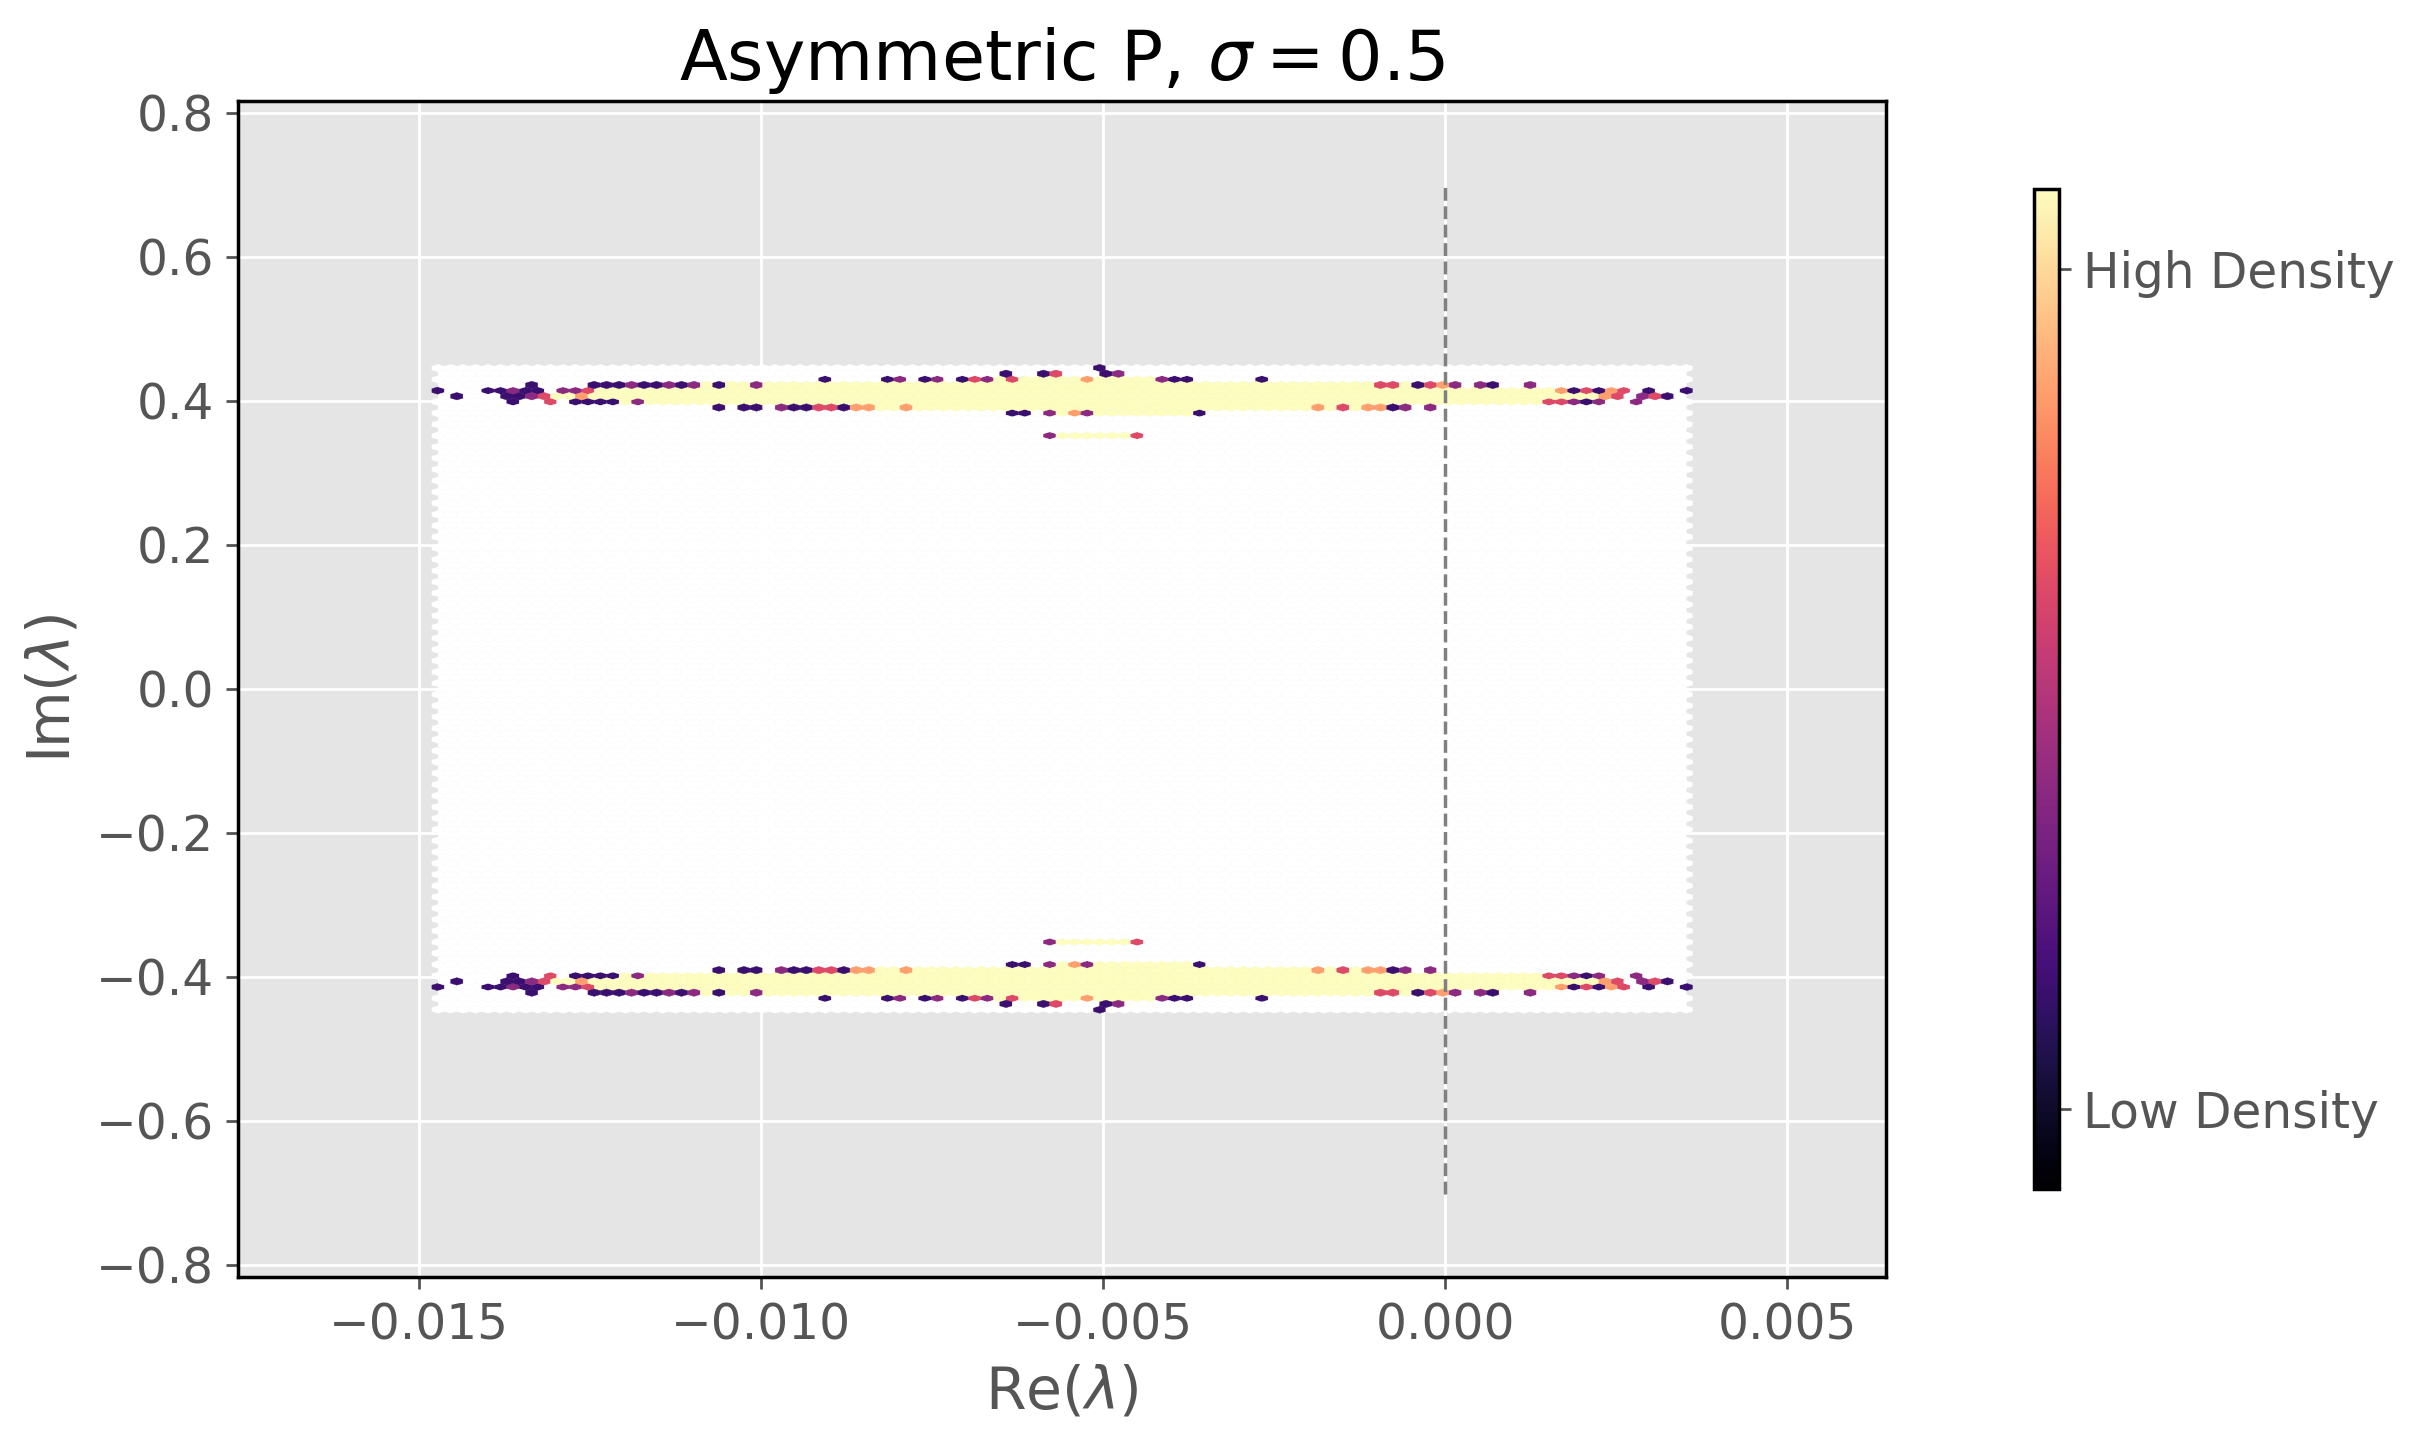

In [158]:
### Plot Eigenvalues of Various Linearized Systems
    ### (Eval'd at the respective steady states for single fixed mu and rho
    
# Loop the code below over a list of sigmas
    # Subplots with left column symmetric, right asymmetric
    # Make list, stability_probs. For each aEVs with different sig, append the
      # ratio of matrices that have any Re(eigval)>0 to k.

#sigs = [0.5,1,2,5,10]
sigs = [0.5]
# just have one pair (sEVs,aEVs) at a time for simplicity
    # generate sEVs, aEVs with current sigma
    # plot them
    # append to stability_freq using aEVs

n = 20      # number of species AND number of resrcs
k = 750     # number of systems to generate

# new
sP = symPvec(sig=1, n=n, k=k)
aP = asymPvec(sig=1, n=n, k=k)

mu = (np.ones(n)*0.5).reshape(n,1)
rho = (np.ones(n)*0.5).reshape(n,1)
# \new

stability_freqs = [] # len(sigs)

for j, s in enumerate(sigs):
    # old
    # sEVs = rand_eigval_gen(n, k, sig = s, symmetric=True)
    # aEVs = rand_eigval_gen(n, k, sig = s, symmetric=False)
    
    # new
    sEVs = eigval_gen(sP, eps, mu, rho)
    aEVs = eigval_gen(aP, eps, mu, rho)
    # \new
    
    for i, q in enumerate([sEVs, aEVs]): # i index, q current value

        x = q.real
        y = q.imag
        
        
        plt.rcParams["axes.edgecolor"] = "black" 
        plt.rcParams["axes.linewidth"] = 1 

        fig, ax = plt.subplots(figsize = (10, 6))

        #cmap = plt.cm.viridis_r  ### old, gets an error
        cmap = mpl.cm.get_cmap("magma").copy()
        cmap.set_under(color = 'white') 

        plt.axvline(0, c='grey', linestyle='--', linewidth=1, ymin=0.07, ymax=0.93) ### stability threshold (Re = 0)

        font = {'size' : 14}
        plt.rc('font', **font)

        
        # plt.subplot(len(sigs),2,(j+i+1));
        plt.hexbin(x, y, bins=None, cmap=cmap, linewidths=0.1) ### bins = 'log' seems unhelpful???

        plt.xlabel(r'Re($\lambda$)')
        plt.ylabel(r'Im($\lambda$)')


        plt.clim(10**(-8), 5.0) ### color limits, increase upper for better contrast ???
        ### originally, (10**(-8), 2.0)

        xmin, xmax = plt.xlim()
        nxm = (xmax - xmin) / 10 ### def'n some padding/margins
        plt.xlim((xmin - nxm, xmax + nxm))


        ### Adjusting Re axis tick marks
        if i==0: ### symmetric P
            loc = plticker.MultipleLocator(base=0.01) ### tick marks in increments of 'base'
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Symmetric P, $\sigma={}$'.format(s))


        if i==1: ### asymmetric P
            loc = plticker.MultipleLocator(base=0.01) ### originally, base = 0.02
            # ax.xaxis.set_major_locator(loc)
            plt.title(r'Asymmetric P, $\sigma={}$'.format(s))
            
        cb = plt.colorbar(aspect=40, shrink=0.85, pad=0.07)
        locs = cb.get_ticks()
        tl = locs[-1] * 2 / 25
        cb.set_ticks([tl, locs[-1] - tl])
        cb.set_ticklabels(['Low Density', 'High Density'])


        ymin, ymax = plt.ylim()
        nym = (ymax - ymin) / 3
        plt.ylim((ymin - nym, ymax + nym))
        
        plt.tight_layout()
    

plt.show();

# Arnoldi Measures

## Misc.

In [159]:
def community_matr_gen(C,P,eps,mu,rho):
    '''
    Generate L, community matrix (Jacobian) of an O'Dwyer system described by given consumption matrix C, production matrix P, and mu, rho.
    '''
    
    n = P.shape[-1]
    k = P.shape[0]
    I = np.identity(n)
        
    LD = np.zeros((k, n, n))

    ## Equilibrium Abundances ##
    R_star = R_star_gen(C, P, eps, mu)
    S_star = S_star_gen(C, P, R_star, rho)
    
    # Community Matrix Partitions
    CS = np.dot(C, S_star).T.reshape(k,n,1) # can use regular .T because first dimension is 1
    CR = np.dot(C, R_star).T.reshape(k,n,1)
    
    LA  = -CS * I
    LB = P - CR * I
    LC = eps * CS * I

    L  = np.concatenate((np.concatenate((LA, LB),2), np.concatenate((LC, LD),2)), 1)
    
    return L

In [160]:
def dom_eigvals(A): # for A shape (k,2*n,2*n) ; returns entire eigval (complex, with sign)
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])    
    k = A.shape[0]
    
    evs = eigvals(A)
    
    dom_ev_ind = (np.argmax(evs.real,-1)) 
    dom_ev = evs[np.arange(0,k), dom_ev_ind]
    
    return dom_ev

In [285]:
dom_eigvals(A[stable_inds[problem_inds[0][0]] ,:,:])
dom_eigval_single(A[stable_inds[problem_inds[0][0]] ,:,:])
asym_res(A[stable_inds[problem_inds[0][0]] ,:,:])

array([-0.0939025+1.7188562j])

(-0.09390250768729319+1.7188562465845858j)

array([0.0939025])

In [161]:
def dom_eigval_single(A):
    evs = eigvals(A)
    
    dom_ev_ind = (np.argmax(evs.real,-1)) 
    dom_ev = evs[dom_ev_ind]
    
    return dom_ev

In [162]:
# dom_eigval_single(A[0,:,:])
# eigvals(A[0,:,:])

In [163]:
# # For spectral norm
# def lambda_dom(A): 
#     if A.ndim == 2:
#         A = A.reshape(1,A.shape[0],A.shape[1])
        
#     evs = eigvals(A)
#     max_ind = np.argmax(evs.real[0], -1)
#     lambda_dom = evs[max_ind]
    
#     return lambda_dom

In [164]:
### LESSON: Do not stack a matrix k times if its just the same one (when operating with another matrix)
## Leave it as single and let numpy do heavy lifting

# prod = np.tensordot(CC,RR,axes=([2],[1]))
# prod.shape
# np.dot(CC[0,:,:],RR[0,:,:])
# np.dot(CC[1,:,:],RR[1,:,:])
# np.dot(CC[2,:,:],RR[2,:,:])

# prodnew = np.transpose(prod.reshape(k,n,k), (0,1,2))
# prodnew.shape
# indv = np.lib.stride_tricks.sliding_window_view(prodnew,(1,4,1))
# indv.shape
# indv

## "Resilience, reactivity and variability..." (2016)

In [165]:
np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
# C = abs(np.random.randn(n,n)) # literally never stable, equilibria are ruined
P = asymPvec(sig = 1, n = n, k = k)

J = community_matr_gen(C,P,eps,mu,rho)
J.shape

(1000, 4, 4)

In [166]:
# R_data = R_star.reshape(R_star.size)
# S_data = S_star.reshape(S_star.size)

In [167]:
from matplotlib.ticker import PercentFormatter

In [168]:
# plt.hist(R_data, bins = 20, weights=np.ones(len(R_data)) / len(R_data), color = 'orange', ec = 'k');
# plt.title(r'Distribution of $R^*$ entries');
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.show();

In [169]:
# plt.hist(S_data, bins = 20, weights=np.ones(len(S_data)) / len(S_data), color = 'deepskyblue', ec = 'k');
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# plt.title(r'Distribution of $S^*$ entries');

In [170]:
# # R is distributed as a sum of half normals (for identity C)
# half_norm = abs(np.random.randn(n*k)).reshape(n,k) ;# get n many half normals (number of entries to be summed), need k many of these for k systems
# data_hn = np.sum(half_norm, 0);
# plt.hist(data_hn, bins =20, weights=np.ones(len(data_hn)) / len(data_hn), color = 'grey', ec='k');

# plt.title('Distribution of sum of n={} half normals'.format(n));
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1));


### Pre-Arnoldi sanity check

In [171]:
# Equilibria
R_star = R_star_gen(C,P,eps,mu)
S_star = S_star_gen(C,P,R_star,rho)

# R_star[0,:,:]
# S_star[0,:,:]

### The 4 measures

In [172]:
# 'A' will mean a (k,2*n,2*n) stack of community matrices (Jacobian evaluated at R_star,S_star)

#### Asymptotic Resilience

In [173]:
def asym_res(A):
    if A.ndim == 2:
        A = A.reshape(1,A.shape[0],A.shape[1])
    
    k = A.shape[0]
    
    
    # dom_ev = dom_eigvals_min(A)
    # dom_ev = lambda_dom(A)
    dom_ev = dom_eigvals(A)
    
    AS = -dom_ev.real # redundant .real, but doesn't hurt
    
    return AS

In [174]:
AR= asym_res(J)
AR.shape
AR[0]

(1000,)

0.03070560031190848

#### Deterministic Invariability
$$\mathcal{I}_D = \frac{1}{\sup_{\omega}||(i\omega - A)^{-1}||}$$

In [293]:
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar # for Brent

# How to optimize omega for stack of A's in parallel?
## Might just settle with for-looping the optimize calls

In [305]:
def spectral_norm(A): # only takes 1 matrix
    dom_ev = dom_eigval_single(np.dot((A.T).conjugate(), A)) # conjugate transpose is NOT superfluous; we subtract A from i*omega

    return np.emath.sqrt((dom_ev.real)) # np.emath.sqrt returns complex if takes negative # Take the real part?

In [306]:
problem_inds[0][0]

1

In [307]:
spectral_norm(A[stable_inds[problem_inds[0][0]] ,:,:])

2.712769342404854

In [308]:
spectral_norm(A[stable_inds[0] ,:,:])

2.3310246924876927

In [309]:
A[stable_inds[problem_inds[0][0]] ,:,:]

array([[-0.9174806,  0.4885181, -0.0755717],
       [ 1.1316294, -0.4469594,  2.1855754],
       [-1.3964963, -1.4441138, -0.2348421]])

In [310]:
eigvals(np.dot((A[stable_inds[problem_inds[0][0]] ,:,:].T).conjugate(),A[stable_inds[problem_inds[0][0]] ,:,:]))
np.sqrt(6.9041165)

array([7.3591175, 0.7055312, 3.369398 ])

2.627568552864035

In [311]:
determ_invar(0.0001,A[stable_inds[problem_inds[0][0]] ,:,:])
asym_res(A[stable_inds[problem_inds[0][0]] ,:,:])

0.8399590615305064

array([0.0939025])

In [312]:
# find omega that maximizes ||inverse(i*om-A)||_{spectral}

# objective function
def determ_invar_OBJ(om, A):
    B = np.linalg.inv(complex(0,om) - A)  # call B the matrix whose spectral norm we aim to maximize    
    return -spectral_norm(B) # negative because we are maximizing

In [313]:
# Brent
guess = 1 # Brent does not take a guess?
out = minimize_scalar(determ_invar_OBJ, bounds = (0,10), args=(J[0,:,:]), method='bounded')

In [314]:
out # out.fun is our (opposite) supremum
# out.x is the omega that achieves it

     fun: -68.01895733845616
 message: 'Solution found.'
    nfev: 30
  status: 0
 success: True
       x: 5.363445511637438e-06

In [315]:
# Deterministic invariance
def determ_invar(om, A): # assumes you have found argmin omega
    # find omega=om that maximizes ||inverse(i*om-A)||_{spectral}, the frequency response
    
    B = np.linalg.inv(complex(0,om) - A)  # call B the matrix whose spectral norm we aim to maximize
    
    return 1 / spectral_norm(B)

In [316]:
determ_invar(out.x, J[0,:,:])

0.01470178372514725

In [317]:
I_D_ex = []
t = np.linspace(-0.1,0.1,1000)
for i in range(len(t)):
    I_D_ex.append( determ_invar(t[i], J[0,:,:]) )

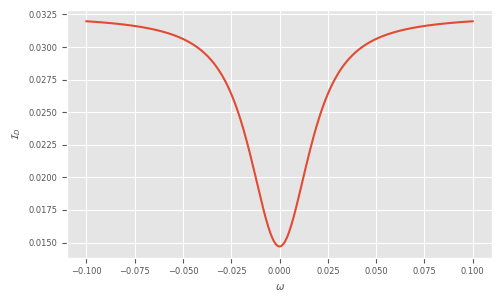

In [318]:
plt.figure(figsize=(5,3),dpi=100);


plt.plot(t, np.array(I_D_ex))
plt.xlabel(r'$\omega$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.tight_layout();

In [319]:
t[np.argmax(I_D_ex)]
np.max(I_D_ex)

-0.1

0.031980308095797806

In [320]:
-1/determ_invar_OBJ(0, J[0,:,:])

0.014701782334127634

In [321]:
# Loop through each Community matrix to get their I_D
I_D = []
oms = []
for i in range(k):
    
    out = minimize_scalar(determ_invar_OBJ, bounds = (0,10), args=(J[i,:,:]), method='bounded')
    
    oms.append(out.x)
    I_D.append(-1/out.fun) # out.fun is still negative bc of obj function minimizing the opposite to find maximum
    

In [322]:
# I_D = 1/np.array(I_D)

In [323]:
J_norms = np.linalg.norm(J, 'fro', axis=(1,2))
# J_norms[0] == np.linalg.norm(J[0,:,:].reshape(1,2*n,2*n), 'fro', axis=(1,2)) # yup, that's 1000 norms

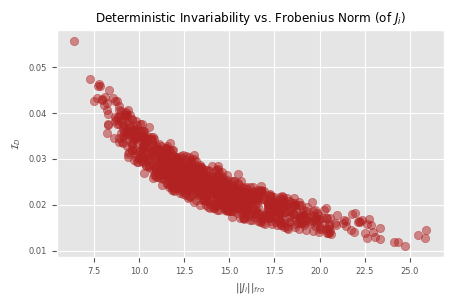

In [324]:
plt.figure(figsize=(5,3),dpi=100);

plt.scatter(x=J_norms, y=I_D, color='firebrick', alpha = 0.5);
plt.title(r'Deterministic Invariability vs. Frobenius Norm (of $J_i$)');
plt.ylabel(r'$\mathcal{I}_D$');
plt.xlabel(r'$|| J_i||_{fro}$');

#### Stochastic Invariability

$$\mathcal{I}_S = \frac{1}{2} ||-\hat{A}^{-1}||^{-1}$$
$$ \hat{A} = A \otimes I + I \otimes A $$

In [325]:
def stoch_invar(A):
    # NOT vectorized bc Kronecker product (at the moment)
    I = np.identity(A.shape[-1])
    A_hat = np.kron(A,I) + np.kron(I,A)
    
    temp = -np.linalg.inv(A_hat)
    spec_norm = spectral_norm(temp)
    
    SI = 0.5 / spec_norm
    
    return SI

In [326]:
I_S = []
for i in range(k):
    I_S.append(stoch_invar(J[i,:,:]))

In [327]:
len(I_S)

1000

In [328]:
I_S[5]

0.00021473752923946202

In [329]:
I_S = np.array(I_S)

#### Initial Resilience

In [330]:
def init_res(A): # real part only, as implied but not defined in the paper. Property of A+A.T ???
    
    if A.ndim == 2:  # to account for when passing a single community matrix A, shape (2*n,2*n)
        A = A.reshape(1,A.shape[0],A.shape[1])
    
    k = A.shape[0]
    
    temp = A + np.transpose(A, (0,2,1)) # symmetric matrices have real eigvals
    
    # dom_evs = dom_eigvals_min(temp)
    # dom_evs = lambda_dom(temp)
    dom_evs = dom_eigvals(temp)
    
    R0 = -0.5* dom_evs.real
    
    return R0

In [331]:
R0 = init_res(J)
R0.shape

(1000,)

In [332]:
# # Agrees with Arnoldi example
# a = np.array([-1,2.5,0.1,-1]).reshape(2,2)
# a
# init_res(a)
# asym_res(a)

In [333]:
# These systems have nearly guaranteed stability for small n (less than 6 or so)

### Arnoldi plots of O'Dwyer Systems

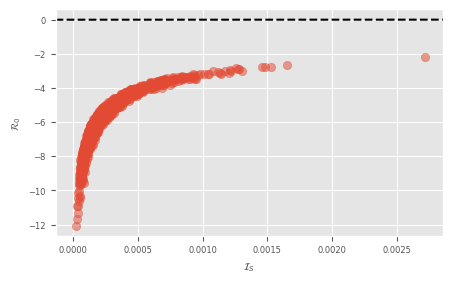

In [334]:
plt.figure(figsize=(5,3),dpi=100);

plt.scatter(I_S, R0, alpha=0.5);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');


In [335]:
np.min(R0)

-12.060222377485552

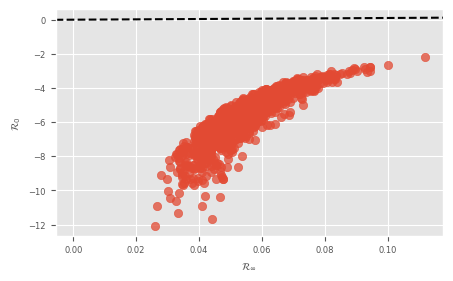

In [336]:
plt.figure(figsize=(5,3),dpi=100);

plt.scatter(x=AR, y=R0, alpha = 0.75);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');
#

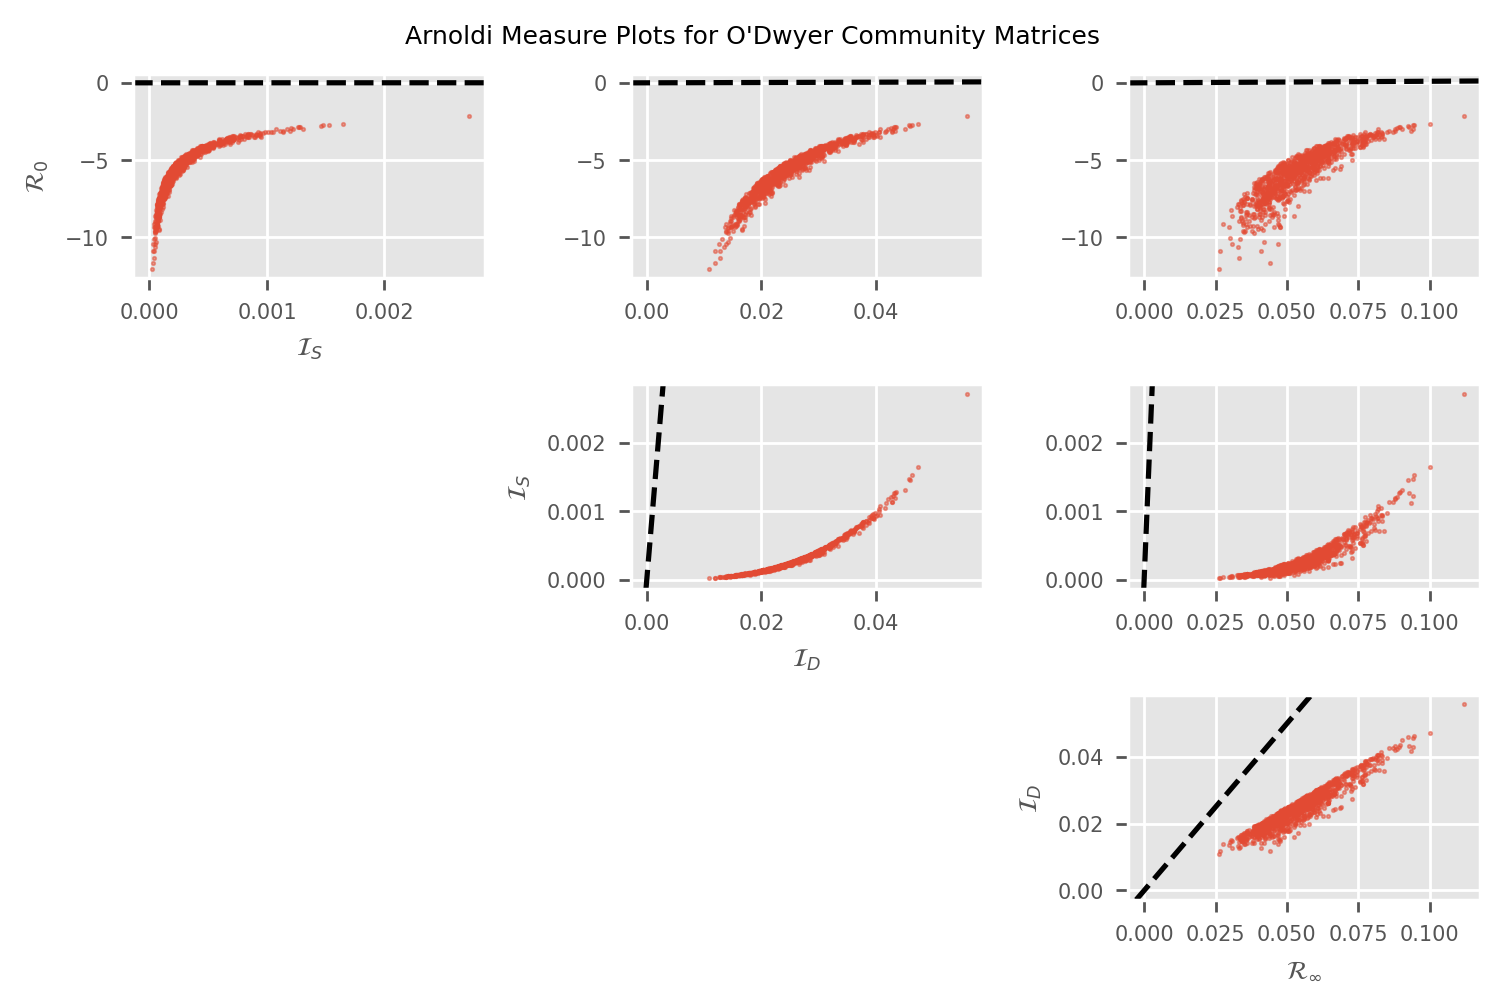

In [337]:
mpl.rcParams['figure.dpi'] = 250
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 6})


plt.subplot(3,3,1)
plt.scatter(x=I_S,y=R0, s = 1,alpha = 0.5);
# plt.xticks(fontsize=3);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,2)
plt.scatter(x=I_D,y=R0, s=1, alpha = 0.5);
# plt.xlabel(r'$\mathcal{I}_D$');
# plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,3)
plt.scatter(x=AR,y=R0, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,5)
plt.scatter(x=I_D,y=I_S, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{I}_D$');
plt.ylabel(r'$\mathcal{I}_S$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,6)
plt.scatter(x=AR,y=I_S, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,9)
plt.scatter(x=AR,y=I_D, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.suptitle('Arnoldi Measure Plots for O\'Dwyer Community Matrices');

plt.tight_layout();

## Copying Arnoldi Plots 

In [338]:
### copy Arnoldi for sanity check

np.random.seed(1)
S = 3
k = 1000
A = np.random.randn(k,S,S)
d = np.random.uniform(-1,0, (k,S))
d_ind = np.diag_indices(S)
A[:, d_ind[0],d_ind[1]] = d
A[0:2,:,:]

array([[[-0.2024137, -0.6117564, -0.5281718],
        [-1.0729686, -0.2353759, -2.3015387],
        [ 1.7448118, -0.7612069, -0.681615 ]],

       [[-0.5456666,  1.4621079, -2.0601407],
        [-0.3224172, -0.049373 ,  1.1337694],
        [-1.0998913, -0.1724282, -0.8243228]]])

In [339]:
A_evs = eigvals(A)

In [340]:
A_reals = A_evs.real

In [341]:
neg_real_cts = np.sum(A_reals<0,-1)
neg_real_cts.shape
stable_inds = np.where(neg_real_cts == S)[0] # S = 3 here, matrix dimension
stable_inds.shape
unstable_inds = np.where(neg_real_cts != S)[0]

(1000,)

(403,)

In [342]:
neg_real_cts[neg_real_cts!=S].size

597

In [343]:
eigvals(A[unstable_inds,:,:]).real

array([[ 1.2959054, -1.207655 , -1.207655 ],
       [-2.3206003,  0.450619 ,  0.450619 ],
       [ 0.2193466, -0.8512737, -0.8512737],
       ...,
       [-1.4688575,  0.2687495,  0.2687495],
       [-1.8327215,  0.1014544,  0.1014544],
       [-0.7098562, -0.7098562,  0.1064997]])

In [344]:
tempR0 = init_res(A[stable_inds,:,:])

In [345]:
tempRinf = asym_res(A[stable_inds,:,:])

In [346]:
tempR0.size
tempR0[tempR0>0].size

403

80

In [347]:
tempI_S = []
for i in stable_inds:
    tempI_S.append(stoch_invar(A[i,:,:]))

In [348]:
tempI_S = np.array(tempI_S)

In [349]:
np.all(eigvals(A)[stable_inds,:]<0)

True

In [350]:
tempI_S.size
tempR0.size

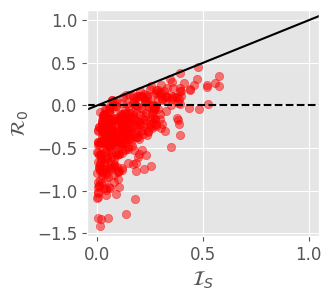

In [351]:
plt.figure(figsize=(3,3), dpi=100)
mpl.rcParams.update({'font.size': 12})

plt.scatter(tempI_S, tempR0, color='r', alpha=0.5);

# plt.scatter(tempI_S, tempR0, color='b', label = 'unstable',alpha = 0.5);
# plt.legend();

plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),xy2=(1,1), color='k');
plt.axhline(y=0,color='k',linestyle='--');


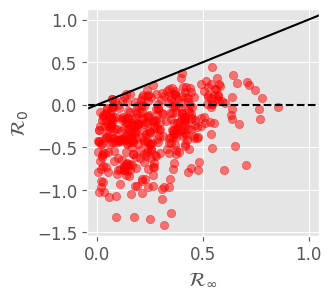

In [352]:
plt.figure(figsize=(3,3), dpi=100)

plt.scatter(x=tempRinf, y=tempR0, color='red', alpha = 0.5);
# plt.title('With both stable and unstable systems');
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{R}_{0}$');
# plt.legend();
plt.axline(xy1=(0,0), xy2=(1,1), color = 'k');
plt.axhline(y=0,color='k',linestyle='--');
plt.show();

In [353]:
A[stable_inds,:,:].shape

(403, 3, 3)

In [378]:
# Loop through each Community matrix to get their I_D
tempI_D = []
temp_oms = []
for i in stable_inds:
    
    # out = minimize_scalar(determ_invar_OBJ, bounds = (0,100), args=(A[i,:,:]), method='bounded')
    out = minimize_scalar(determ_invar_OBJ, args=(A[i,:,:]), method='brent')
    
    temp_oms.append(out.x)
    tempI_D.append(-1/out.fun)

In [379]:
tempI_D = np.array(tempI_D)

In [385]:
temp_oms = np.array(temp_oms)

In [386]:
temp_oms

array([ 1.1765706e+07,  2.8027625e+07,  1.4224516e+07,  3.9408647e+06,
        1.0798873e+07,  1.0450750e-11, -4.4070698e-10,  3.5113031e+07,
        4.5101167e+07, -2.9953746e-09,  1.7997982e+06, -2.3349683e-10,
        4.4077728e+06,  1.0224412e+06,  1.3935063e-11,  1.7462418e+07,
        1.1721090e-11,  1.8451311e+07,  5.1005119e-08,  2.1850954e+07,
        1.8797289e+07,  1.1940361e+08,  5.0113317e+07,  1.8710638e-08,
        1.7193523e+07, -6.0379833e-09,  2.6055123e+06, -1.6385886e-10,
        1.8079769e-11,  5.2123318e-10, -1.3805944e-09, -1.3257545e-09,
        6.5583171e-08,  3.4677298e+07,  1.3941894e-11,  5.8418340e-09,
       -4.8669000e-10,  1.9804544e-09, -7.2922754e-11,  1.5394839e-11,
        9.5271868e-09,  1.6204981e-09,  2.1913607e+07,  1.8474251e-11,
        1.7192811e+07, -4.2902673e-11,  3.3666211e+07,  1.5970445e-11,
       -6.8735288e-10,  1.4352884e+07,  1.5611058e-11, -1.6877420e-11,
        6.8901320e-09,  1.1266648e-11,  7.1486616e+06,  3.3385288e+07,
      

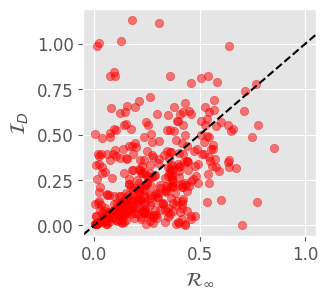

In [381]:
plt.figure(figsize=(3,3),dpi=100)

plt.scatter(x=tempRinf, y=tempI_D, color='r', alpha=0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_{D}$');
# plt.legend();
plt.axline(xy1=(0,0), xy2=(1,1), color = 'k', linestyle ='--');
# plt.xlim(0,1.5);
plt.show();

In [382]:
problem_inds = np.where(tempI_D>tempRinf) # where does tempI_D break the rules

In [383]:
problem_inds[0]

array([  1,   9,  10,  11,  16,  19,  23,  28,  32,  34,  38,  40,  45,
        46,  47,  54,  55,  56,  59,  60,  62,  69,  72,  78,  80,  84,
        88,  91,  94,  95,  97, 103, 104, 106, 108, 111, 113, 114, 118,
       122, 126, 131, 133, 138, 139, 146, 147, 150, 151, 152, 153, 159,
       162, 167, 168, 169, 170, 175, 176, 178, 179, 180, 183, 184, 193,
       195, 196, 203, 207, 208, 209, 210, 214, 215, 216, 218, 220, 221,
       222, 224, 228, 229, 232, 236, 240, 241, 246, 248, 254, 255, 256,
       259, 260, 262, 272, 276, 281, 282, 284, 286, 287, 292, 294, 297,
       298, 304, 306, 307, 315, 320, 324, 327, 329, 330, 331, 335, 337,
       341, 342, 346, 351, 356, 357, 359, 361, 363, 366, 370, 371, 373,
       374, 375, 385, 386, 388, 389, 390, 391, 392, 396, 399, 400, 401],
      dtype=int64)

In [384]:
(problem_inds)[0].size
stable_inds[problem_inds]

143

array([  7,  28,  31,  33,  46,  54,  68,  78,  84,  87,  94,  98, 114,
       115, 116, 134, 135, 137, 151, 154, 159, 180, 190, 205, 212, 219,
       232, 240, 246, 249, 254, 266, 271, 279, 282, 288, 295, 297, 312,
       321, 329, 339, 345, 359, 364, 386, 391, 399, 406, 411, 412, 424,
       433, 441, 449, 450, 451, 467, 468, 471, 473, 475, 480, 488, 512,
       514, 515, 533, 541, 544, 545, 546, 557, 558, 559, 565, 571, 575,
       577, 580, 590, 592, 595, 599, 608, 609, 619, 625, 636, 637, 641,
       650, 654, 659, 675, 683, 695, 701, 708, 712, 713, 733, 736, 741,
       743, 752, 761, 762, 783, 790, 796, 800, 804, 814, 815, 829, 834,
       849, 851, 857, 873, 883, 885, 889, 898, 917, 924, 934, 936, 939,
       940, 942, 963, 964, 966, 970, 971, 975, 977, 983, 991, 992, 993],
      dtype=int64)

In [375]:
# eigvals(A[stable_inds[problem_inds]])

In [376]:
problem_inds[0][0]

1

In [377]:
I_D_ex = []
t = np.linspace(0,5,1000) #symmetric
for i in range(len(t)):
    I_D_ex.append(-1/determ_invar_OBJ(t[i], A[stable_inds[7],:,:]))

t[np.argmax(I_D_ex)]
np.max(I_D_ex)

I_D_ex = np.array(I_D_ex)

0.0

0.31822816548884725

C:\Users\riley\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


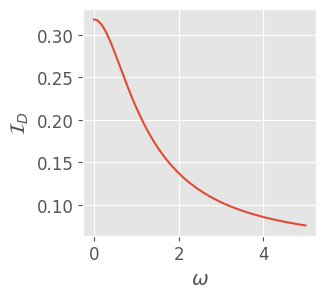

In [244]:
plt.figure(figsize=(3,3),dpi=100)

plt.plot(t, np.array(I_D_ex))
plt.xlabel(r'$\omega$');
plt.ylabel(r'$\mathcal{I}_D$');

In [245]:
np.all(A_evs[stable_inds][problem_inds].real <0)

True

In [246]:
plt.figure(figsize=(3,3),dpi=100)

plt.scatter(x=tempRinf[problem_inds], y=tempI_D[problem_inds], color='b', alpha=0.5);
# plt.title('With both stable and unstable systems');
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_{D}$');
# plt.legend();
plt.axline(xy1=(0,0), xy2=(1,1), color = 'k', linestyle ='--');
# plt.xlim(0,1.5);
plt.show();

In [258]:
tempRinf[problem_inds[0][0]]

0.09390250768729319

In [257]:
tempI_D[problem_inds[0][0]]

(0.12042934279420336-7.399737436510036e-26j)

In [271]:
I_D_ex = []
t = np.linspace(0,2,1000)
# I_D_ex = np.apply_along_axis(determ_invar_OBJ, 0, t)
for i in range(len(t)):
    I_D_ex.append(determ_invar(t[i], A[stable_inds[problem_inds[0][10]],:,:])) # multiply by -1 to account for objective function's negative

In [272]:
max(I_D_ex)

(1.122584839487071-1.6875780545705228e-17j)

<Figure size 300x300 with 0 Axes>

C:\Users\riley\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(1.122584839487071-1.6875780545705228e-17j)

2.0

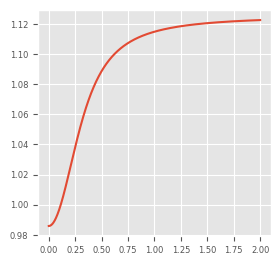

In [273]:
plt.figure(figsize=(3,3),dpi=100);

plt.plot(t,I_D_ex);
np.max(I_D_ex);
t[np.argmax(I_D_ex)]

NameError: name 'temp_I_s' is not defined

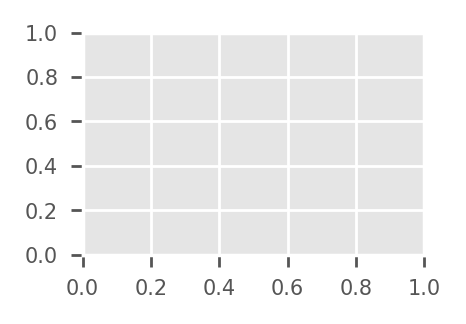

In [250]:
mpl.rcParams['figure.dpi'] = 250
plt.style.use('ggplot')
mpl.rcParams.update({'font.size': 6})


plt.subplot(3,3,1)
plt.scatter(x=tempI_s,y=R0, s = 1,alpha = 0.5);
# plt.xticks(fontsize=3);
plt.xlabel(r'$\mathcal{I}_S$');
plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,2)
plt.scatter(x=I_D,y=R0, s=1, alpha = 0.5);
# plt.xlabel(r'$\mathcal{I}_D$');
# plt.ylabel(r'$\mathcal{R}_0$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,3)
plt.scatter(x=AR,y=R0, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,5)
plt.scatter(x=I_D,y=I_S, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{I}_D$');
plt.ylabel(r'$\mathcal{I}_S$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,6)
plt.scatter(x=AR,y=I_S, s=1, alpha = 0.5);
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.subplot(3,3,9)
plt.scatter(x=AR,y=I_D, s=1, alpha = 0.5);
plt.xlabel(r'$\mathcal{R}_{\infty}$');
plt.ylabel(r'$\mathcal{I}_D$');
plt.axline(xy1= (0,0),slope=1, color='k', linestyle='--');

plt.suptitle('Arnoldi Measure Plots for O\'Dwyer Community Matrices');

plt.tight_layout();

### Distribution of community matrix entries
#### Also, of equilibria vectors

## "How ecosystems recover ..." (2018)

"We showed that in large, complex communities, due to the presence
of species with very different abundances, asymptotic resilience need not even be a good predictor 
of return rates at longer times."

"[...] asymptotic resilience should not be used as a proxy for the short-term recovery."

(pg. 8 "How ecosystems recover[...]")

In [ ]:
### Arnoldi  "How ecosystems recover..."
n = 20 #repeated
import scipy as sp # for matrix exponential
from scipy.linalg import expm

In [ ]:
# Return Rates
def R_avg(x, t, u):
    '''
    Average rate of return at current displacement 'x' after time 't' since initial perturbation 'u'
    '''
    return -( np.log(np.linalg.norm(x,2)) - np.log(np.linalg.norm(u,2))) / t

In [ ]:
# Arnoldi Appendix E suggests def'n v with v_i std Gaussian, then normalize to u. Why Gaussian?? 
def u_gen_unif(n):
    '''
    Generate uniformly distributed unit-length  perturbation vector u.
    
    The direction is ostensibly the uniformly distributed value.
    '''
    v = np.random.normal(0,1,n) # so-called 'v' in Arnoldi
    return v/np.linalg.norm(u,2) # does this provide uniformly distributed perturbation direction? They say so.

In [ ]:
# Really, according to Arnoldi, perturbations should tend to have greater effect on more abundant species.
# This is pretty subjective, I suppose? Is there empirical justification for this 'tendency'?

In [ ]:
# Perturbation covariance matrix, Cov, for uniform perturbation direction
Cov_unif = np.identity(n)/n # for when equilibrium populations not being considered in perturbation distribution

In [ ]:
# Choose an example system for testing Arnoldi measures
n_arn = 5
k_arn = 2
sig_arn = 1
eps = 0.25
c = 1
I = np.identity(n_arn)*c
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn)

In [ ]:
R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
R_arn
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
S_arn

In [ ]:
S_star_gen?

In [ ]:
LA  = -c * S_arn * I

LB = aP_arn - c * R_arn * I

LC = eps * c * S_arn * I
LD = np.zeros((k_arn,n_arn, n_arn))

L_top = np.concatenate((LA, LB), 2)
L_bot = np.concatenate((LC, LD), 2)
L_arn  = np.concatenate((L_top,L_bot), 1)

In [ ]:
R_arn

In [ ]:
RS_star = np.concatenate((R_arn,S_arn), 1) #(k,2*n,1), an example equilibrium
RS_star1, RS_star2 = RS_star

LAM = np.sum(np.square(RS_star)) #lambda, from Arnoldi Appendix E
Cov_prop = np.zeros((k_arn, 2*n_arn, 2*n_arn))
di_C = np.diag_indices(2*n_arn)
#Below LHS will be (k_arn, n_arn)
Cov_prop[:,di_C[0],di_C[1]] = (np.square(RS_star)/LAM).reshape(k_arn,2*n_arn) ### From Arnoldi Appendix E, Covariance matrix when u_i prop. to N*_i

In [ ]:
#Appendix E says the following:
def u_gen_prop(n, Nstar):
    ''' 
    Generate random perturbation 'u' such that u_i proportional to N*_i (population-proportional perturbations).
    '''
    v = np.random.normal(0,1,2*n).T
    D = np.diag(Nstar.reshape(2*n))
    w = np.dot(D,v) # really just pairwise multiplication of Nstar and v
    u = w/np.linalg.norm(w,2)
    return u

# This is a more suitable perturbation model: Expectation of u_i proportional to N*_i

In [ ]:
### Median approximations
def disp_median(A,Cov,t): # community matrix A, Covariance matrix Cov, time t
    # displacement = ||x(t)||
    return np.sqrt(np.trace(expm(A*t)*Cov*expm(A.T*t)))

def R_avg_median(A,Cov,t): 
    '''Median of the average return rates'''
    return -(np.log(np.trace(expm(A*t)*Cov*expm(A.T*t))) - np.log(np.trace(Cov))) / (2*t)

In [ ]:
disp_med = disp_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
disp_med

R_avg_med = R_avg_median(L_arn[0,:,:], Cov_prop[0,:,:], 1)
R_avg_med

In [ ]:
### Return time 
#c, chosen threshold distance from equilibrium
# T(c) = min(t) such that ||x(t+s)|| <= c for all s>=0 #(does not displace back out of threshold once it reaches return time)

# This will require a numerical solution

In [ ]:
### Numerical solution to a simple system
# Careful of going back and re-running above blocks, reusing a lot of vars here
n_arn = 2
k_arn = 1
sig_arn = 1
eps = 0.25
c = 1
mu_arn = np.ones(n_arn).reshape(n_arn,1) # important, must be column vector
rho_arn = np.ones(n_arn).reshape(n_arn,1)

aP_arn = asymPvec(sig_arn,n_arn,k_arn)
C_arn = np.identity(n_arn) * c

R_arn = R_star_gen(C_arn, aP_arn, eps, mu_arn)
S_arn = S_star_gen(C_arn, aP_arn, R_arn, rho_arn)
RS_arn = np.concatenate((R_arn,S_arn),1)

In [ ]:
R_star_gen?

In [ ]:
RS_arn

In [ ]:
u_ex = u_gen_prop(n_arn,RS_arn.reshape(4))
np.linalg.norm(u_ex,2) #cool?

In [ ]:
u_ex

In [ ]:
# Just working with one example system, can get rid of "Stacking" for simplicity
aP_arn = aP_arn.reshape(n_arn,n_arn)
RS_arn = RS_arn.reshape(2*n_arn,1)

In [ ]:
aP_arn
RS_arn

In [ ]:
# Start with simple n=2 system for convenience starting out
def ResrcProd(N, t, C, P, mu, rho, eps): # why t? Unused

    R0, R1, S0, S1 = N # Ok, Resources are much more abundant

    dNdt = [rho[0]-R0*(C[0,0]*S0 + C[0,1]*S1) + P[0,0]*S0 + P[0,1]*S1,
            rho[1]-R1*(C[1,0]*S0 + C[1,1]*S1) + P[1,0]*S0 + P[1,1]*S1,
            eps*S0*( (C.T)[0,0]*R0 + (C.T)[0,1]*R1 ) - S0*((P.T)[0,0] + (P.T)[0,1]) - mu[0]*S0,
            eps*S1*( (C.T)[1,0]*R0 + (C.T)[1,1]*R1 ) - S1*((P.T)[1,0] + (P.T)[1,1]) - mu[1]*S1
           ]

    return dNdt

In [ ]:
step = ResrcProd(list(RS_arn.reshape(2*n_arn)), 1, C_arn, aP_arn, list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps)

In [ ]:
step
len(step)

In [ ]:
from scipy.integrate import odeint
import pandas as pd # once we start numerical solutions, might make sense to switch to dataframes

In [ ]:
# Numerical solution for (2,2) system

t = np.linspace(0, 100, 1001) # time to simulate
RS_arn
u_2 = u_gen_prop(n_arn,RS_arn)
np.linalg.norm(u_2,2) # works
u_2 # proportions look good



In [ ]:
init_cond = list(u_2+RS_arn.reshape(2*n_arn))
u_2
RS_arn
init_cond

In [ ]:
sol = odeint(ResrcProd, init_cond, t, args=(C_arn, aP_arn.reshape(2,2), list(mu_arn.reshape(2)), list(rho_arn.reshape(2)), eps))

In [ ]:
sol.shape
sol = np.array(sol)

In [ ]:
plt.plot(t, sol[:,0], 'r', label = 'R0');
plt.plot(t, sol[:,1],'b', label = 'R1');
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();

plt.title('2-resource, 2-species asymmetric system')
plt.xlabel('Time, t');
plt.ylabel('Abundance');

In [ ]:
# giving the little guys a chance
plt.plot(t, sol[:,2],'r--', label = 'S0');
plt.plot(t, sol[:,3],'b--', label = 'S1');
plt.legend();


In [ ]:
plt.plot(sol[:,2], sol[:,3], 'g');
plt.title('Phase Plane (Reactive System)');
plt.xlabel(r'$S_1$');
plt.ylabel(r'$S_0$');

In [ ]:
### NEXT STEPS FOR ARNOLDI TOOLS:
    ### Pick a threshold for the oscillations such that settles in ...

In [ ]:
RS_arn
sol

In [ ]:
RS_arn

In [ ]:
sol_xs = np.tile(RS_arn.reshape(4), (len(t), 1)) - sol # running difference between each state variable and its respective equilibrium
sol_xs

In [ ]:
# plt.plot(t, sol[:,0], 'r', sol[:,1],'b', sol[:,2],'r--', sol[:,3],'b--');

# Old O'Dwyer Stuff

In [ ]:
### Plot Grid Representing Production Matrix P ###

for i, M in enumerate([sP, aP]):
    
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'green'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                    cmap=c_map)

    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis = 'both',          
                    which = 'both',      
                    bottom = 'off',      
                    top = 'off',         
                    labelbottom = 'off',
                    left = 'off',
                    right = 'off')

    ax.grid(False)
plt.show();

In [ ]:
### Plot grid representing consumption C ###

C = c*I

for M in [C]:
    c_map = mpl.colors.LinearSegmentedColormap.from_list('my_colormap',
                                               ['white', 'navy'],
                                               256)
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.linewidth"] = 1

    fig, ax = plt.subplots()

    img = plt.imshow(M, interpolation='nearest',
                        cmap=c_map)


    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    plt.tick_params(axis='both',          
                    which='both',      
                    bottom='off',      
                    top='off',         
                    labelbottom='off',
                    left='off',
                    right='off')

    ax.grid(False)


# Diversity Measures
$$ ^q \lambda = \sum^{S}_{i=1} p_i^q$$
For $q=1$, all species weighted equally, "without favoring either common or rare species."

All diversity indices
of a given order $q$ have the same true diversity $^qD$

In [387]:
# same as from Arnoldi measures
np.random.seed(667)
n = 2
k = 1000
mu = (np.ones(n)*1).reshape(n,1)
rho = (np.ones(n)*1).reshape(n,1)
eps = 0.25
C = np.identity(n)
P = asymPvec(sig = 1, n = n, k = k)

J = community_matr_gen(C,P,eps,mu,rho)
J.shape

(1000, 4, 4)

## Jost    
Redo these diversity measures to just do the normalization/sum-to-one'ing for you?


H_A, H_B are any orthogonal quantities/qualities of a diversity index H (EX: alpha and beta diversity, evenness and richness).

All indices will be in numbers equivalent form, D.

In [388]:
# misc
def normalize(N):
    '''
    Make column vector(s) have length 1.
    '''
    if N.ndim == 2:
        N = N.reshape(1,N.shape[0],N.shape[1])
        
    norms = np.sqrt(np.sum(np.square(N),1)).reshape(N.shape[0],1,1)
    
    N = N/norms
    
    return N

In [389]:
def sum_to_one(N):
    '''
    Make column vector(s) sum to 1.
    '''
    if N.ndim == 2:
        N = N.reshape(1,N.shape[0],N.shape[1])
        
    return N/np.sum(N,1).reshape(N.shape[0],1,1)

### Shannon Entropy
$$H \equiv -\sum^{S}_{i=1} p_i \ln(p_i)$$
$$ D = e^{H}$$
H:
$$ H_A + H_B = H_{tot}$$
D (exponential of Shannon entropy):
$$ H_A \times H_B = H_{tot}$$

In [390]:
def shannon_entropy(N):
    return np.exp(-np.sum(N*np.log(N), 1)).reshape(N.shape[0],1,1)

In [391]:
# R_star = R_star_gen(C,P,eps,mu)

In [392]:
s_star = sum_to_one(S_star)
r_star = sum_to_one(R_star)

In [393]:
shannon_s = shannon_entropy(s_star)

shannon_r = shannon_entropy(r_star)
shannon_sr = np.concatenate((shannon_s,shannon_r))

### Simpson concentration
$$H \equiv \sum^{S}_{i=1} p_i^2$$
$$D = \frac{1}{H}$$
$$ H_A \times H_B = H_{tot}$$

In [394]:
def simpson_conc(N):
    H = np.sum(np.square(N),1)
    
    D = 1/H
    
    return D # not reshaped, so it prints not obnoxiously
# Numbers equiv. is reciprocal, already taken here

In [395]:
simpson_s = simpson_conc(s_star)
simpson_r = simpson_conc(r_star)

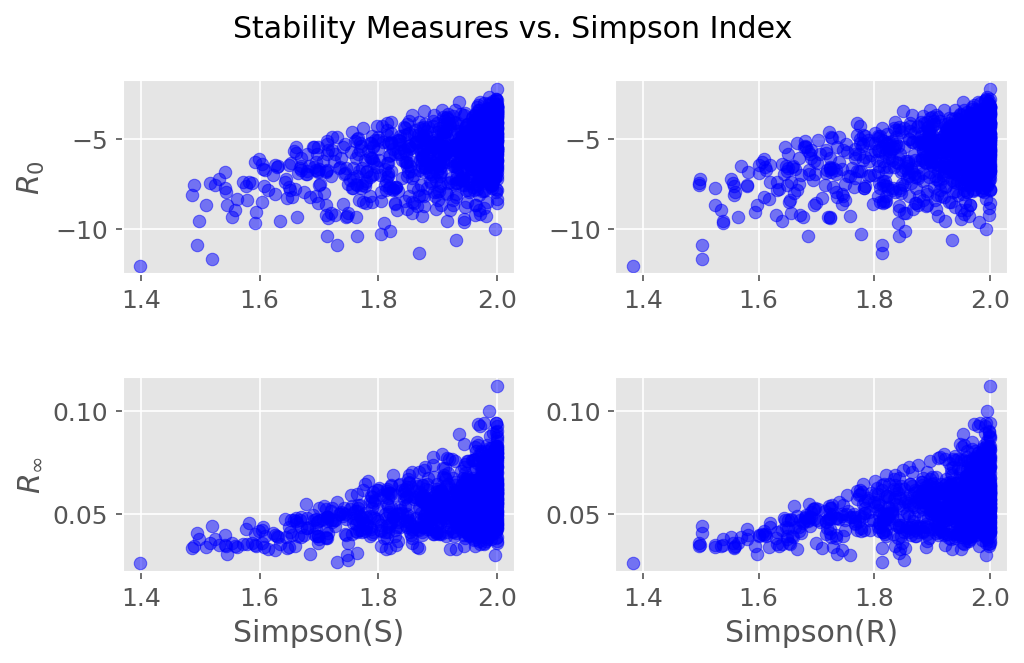

In [396]:
# O'Dwyer
plt.figure(figsize=(7,6),dpi=150);
plt.suptitle('Stability Measures vs. Simpson Index');

plt.subplot(3,2,1);
plt.scatter(simpson_s, R0, alpha=0.5, color = 'blue');
# plt.title('Species Diversity', fontsize=10);
plt.ylabel(r'$R_{0}$');

plt.subplot(3,2,2);
plt.scatter(simpson_r, R0, alpha=0.5, color = 'blue');
# plt.title('Resource Diversity', fontsize=10);

plt.subplot(3,2,3);
plt.scatter(simpson_s, AR, alpha=0.5, color = 'blue');
# plt.title('Resource Diversity', fontsize=10);
plt.ylabel(r'$R_{\infty}$');
plt.xlabel('Simpson(S)');

plt.subplot(3,2,4);
plt.scatter(simpson_r, AR, alpha=0.5, color = 'blue');
# plt.title('Resource Diversity', fontsize=10);
plt.xlabel('Simpson(R)');


plt.tight_layout();

### Gini-Simpson index
$$H \equiv 1 - \sum^{S}_{i=1} p_i^2$$
$$ D = 1/(1-H) $$
$$ H_A + H_B - (H_A \times H_B) = H_{tot}$$

In [397]:
def gini_simpson_index(N):
    H = 1 - np.sum(np.square(N), axis = 1)
    
    D = 1/(1-H)
    
    return D

In [398]:
gini_simp_s = gini_simpson_index(s_star)
gini_simp_r = gini_simpson_index(r_star)
gini_simp_sr = np.concatenate((gini_simp_s,gini_simp_r))

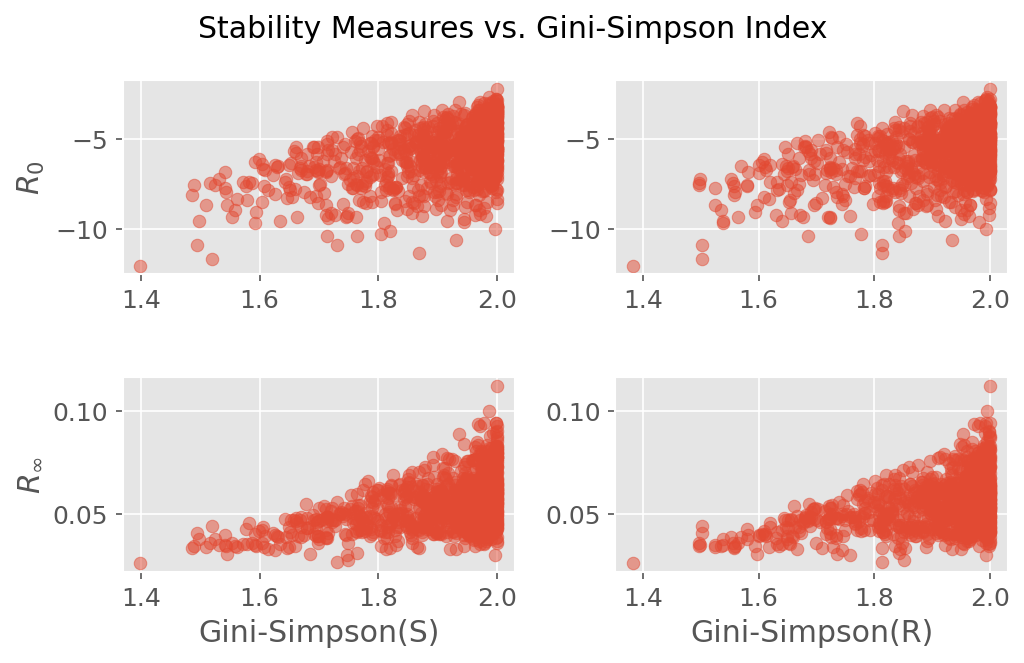

In [399]:
# O'Dwyer
plt.figure(figsize=(7,6),dpi=150);
plt.suptitle('Stability Measures vs. Gini-Simpson Index');

plt.subplot(3,2,1);
plt.scatter(gini_simp_s, R0, alpha=0.5);
# plt.title('Species Diversity', fontsize=10);
plt.ylabel(r'$R_{0}$');

plt.subplot(3,2,2);
plt.scatter(gini_simp_r, R0, alpha=0.5);
# plt.title('Resource Diversity', fontsize=10);

plt.subplot(3,2,3);
plt.scatter(gini_simp_s, AR, alpha=0.5);
# plt.title('Resource Diversity', fontsize=10);
plt.ylabel(r'$R_{\infty}$');
plt.xlabel('Gini-Simpson(S)');

plt.subplot(3,2,4);
plt.scatter(gini_simp_r, AR, alpha=0.5);
# plt.title('Resource Diversity', fontsize=10);
plt.xlabel('Gini-Simpson(R)');


plt.tight_layout();

In [400]:
plt.figure(figsize=(7,4),dpi=150);

plt.subplot(1,2,1);
# plt.scatter(gini_simp_s, AR, alpha=0.5);
plt.scatter(gini_simp_s, I_S.real, alpha=0.5)
# plt.title('Resource Diversity', fontsize=10);
plt.xlabel('Gini-Simpson(S)');
plt.ylabel(r'$\mathcal{I_{S}}$');

plt.subplot(1,2,2);
plt.scatter(gini_simp_r, I_S.real, alpha=0.5)
# # plt.title('Resource Diversity', fontsize=10);
plt.xlabel('Gini-Simpson(R)');



# plt.tight_layout();

AttributeError: 'NoneType' object has no attribute 'set_size'

<Figure size 1050x600 with 1 Axes>

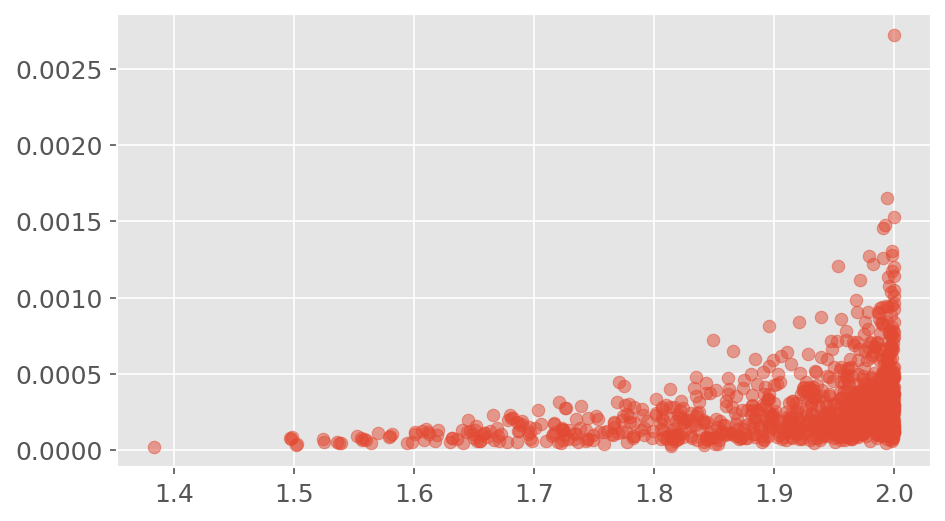

In [401]:
plt.figure(figsize=(7,4),dpi=150);

plt.scatter(gini_simp_r, I_S.real, alpha=0.5);


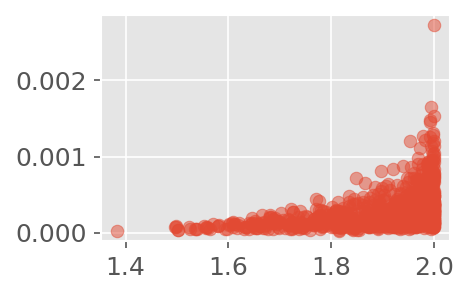

In [402]:
plt.figure(figsize=(3,2),dpi=150);

plt.scatter(gini_simp_r, I_S.real, alpha=0.5);


In [ ]:
I_S.size

### HCDT entropy
$$ H \equiv \frac{1 - \sum^{S}_{i=1} p_i^q}{q-1} $$
$$ D = [(1-(q-1)H)]^{1/(1-q)} $$
$$ H_A + H_B - (q-1)(H_A)(H_B) = H_{tot}$$

### Renyi entropy
$$ H \equiv \frac{-\ln\sum^{S}_{i=1} p_i^q}{q-1} $$
$$ D = e^H $$
$$ H_A + H_B = H_{tot}$$

### Universal
$$ ^q D_{tot} = ^q D_A \times ^qD_B$$
$$ D(H_{\gamma}) = D(H_{\alpha})D(H_{\beta}) $$ (Whittaker's law) 

"True beta diversity (the numbers equivalent of the beta component
of any diversity index) thus has a uniform interpretation
regardless of the diversity index used: it is the effective
number of distinct communities or samples in the
region."

$$^qD_{\alpha} \equiv D(^q\lambda_{\alpha})$$ 
$$ =  \left[ \frac{\sum^C_{j=1}[w^q_j \sum^S_{i=1} (p^q_{ij})]}{\sum^C_{j=1}(w^q_j)} \right]^{1/(1-q)} $$

where S is number of species, C is number of communities, $w_j$ is statistical weight of community $j$, and q is partiality to rare or common species.

Above undefined for q=1. Limit:
$$^1 D_{\alpha} = exp\left[ \sum^C_{j=1}[-w_j \sum^S_{i=1}(p_{ij}\ln p_{ij})] \right]$$

Alpha:
$$ ^qD_{\alpha} = ^q \lambda^{1/(1-q)}_{\alpha}$$
Gamma:
$$ ^qD_{\gamma} = ^q \lambda^{1/(1-q)}_{\gamma}$$

Also, equations for gamma numbers equiv

In [ ]:
# Universal numbers equivalent
def numbers_equiv_alpha(w,p,q):
    '''
    There are C communities and S species.
    
    Takes community weights w (vector of length C), species probabilities p (size (S,C) ), and order of diversity index q.
    Returns numbers equivalent of diversity index's alpha component.
    '''
    w = w.reshape(p.shape[0],1)
    
    if (q==1): # undefined case, need formula that takes the limit as q->1
        D_alpha = np.exp(np.sum(-w * np.sum(p*np.log(p),1) ))

    else:
        num = np.sum(np.power(w,q)*np.sum(np.power(p,q),1) ) # take the species sums of p with axis=0
        den = np.sum(np.power(w,q))
        
        D_alpha = np.power(num/den, 1/(1-q))
        
    return D_alpha

In [ ]:
def numbers_equiv_gamma(w,p,q):
    w = w.reshape(p.shape[0],1,1)
    
    weight_sum = np.sum(w*p)
    
    if (q==1):
        D_gamma = np.exp(np.sum(-weight_sum*np.log(weight_sum)))
        
    else:
        # Really, Jost only explicitly gives formula for even weights. Should work like this, right?
        
        D_gamma = np.power(np.sum(w*p), q)
        D_gamma = np.power(D_gamma, 1/(1-q))
        
    return D_gamma 

In [ ]:
k
n = 2

In [ ]:
w = np.ones(k)/k# assume k equally weighted communities? Like from k different communities
D1_alpha = numbers_equiv_alpha(w, s_star, 1)

D1_gamma = numbers_equiv_gamma(w, s_star, 1)
print('alpha: ', D1_alpha)
print('gamma: ', D1_gamma)
D1_beta = D1_gamma/D1_alpha
print('beta: ', D1_beta)

In [ ]:
s_star.shape

In [ ]:
D1_alpha